In [73]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle

In [230]:
%run Model.ipynb

In [75]:
problems = load_problems("/Users/simonhusebo/Dokumenter/MASTERS CODE/data")
problem_types = ['16_4_4', '30_5_7','42_7_10','72_9_18','121_11_35','300_20_70']

<Axes: title={'center': 'Instance: 1'}>

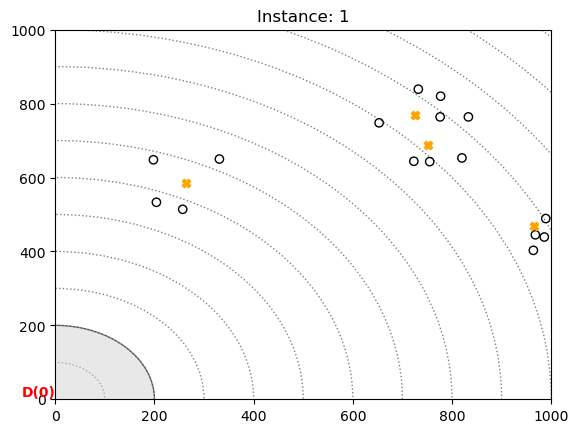

In [113]:
instance = 1
problem = problems[instance-1]
n_trips = problem['N_trips']
initial = initial_solution(problem,n_trips)
operators = [random_remove_greedy_insert,largest_trip_remove_greedy_insert,similarity_removal_greedy_insert,worst_removal_greedy_insert,smallest_trip_removal_greedy_insert,random_remove_kregret_insert,largest_trip_remove_kregret_insert,similarity_removal_kregret_insert,worst_removal_kregret_insert,smallest_trip_removal_kregret_insert,clustering_removal_kncs_greedy_insert,clustering_removal_krd_greedy_insert,clustering_removal_kncs_kregret_insert,clustering_removal_krd_kregret_insert]
weights = [1/4,1/4,1/4,1/16,1/16]
show_the_map(problem, title = instance,save_ = False, save_name = "/Users/simonhusebo/Dokumenter/MASTERS CODE/figures/instance"+str(instance)+".png")


In [114]:
#sol,cost,n_feasible,cost_movement = simple_sim_annealing(inital,problem,operators,probabilities)

In [115]:
best_solution,processed_best,best_cost,best_costs,costs,all_weights,all_scores,all_used,final_improvement,unique,accept_list, deltas = ALNS(initial,problem,operators,1000)

Starting ALNS
Best cost: 67949.70999999999


In [116]:
processed_best

([(10, 0),
  (14, 1),
  (5, 0),
  (20, 0),
  (20, 1),
  (6, 0),
  (6, 1),
  (8, 1),
  (16, 1),
  (0, 0),
  (7, 0),
  (9, 0),
  (9, 1),
  (15, 1),
  (10, 1),
  (2, 0),
  (0, 0),
  (13, 0),
  (13, 1),
  (16, 0),
  (17, 0),
  (17, 1),
  (8, 0),
  (18, 0),
  (18, 1),
  (5, 1),
  (11, 0),
  (11, 1),
  (12, 0),
  (12, 1),
  (19, 0),
  (19, 1),
  (0, 0),
  (14, 0),
  (15, 0),
  (7, 1),
  (1, 0),
  (0, 0)],
 [3, 2, 3, 1],
 [[], [(2, 748.5600000000001)], [], [(1, 219.01000000000008)]])

In [340]:
feasible_trips(processed_best,problem)

(True,
 [(13, 0),
  (13, 1),
  (16, 0),
  (16, 1),
  (17, 0),
  (17, 1),
  (19, 0),
  (19, 1),
  (7, 0),
  (7, 1),
  (6, 0),
  (6, 1),
  (20, 0),
  (11, 0),
  (11, 1),
  (10, 0),
  (10, 1),
  (9, 0),
  (9, 1),
  (12, 0),
  (12, 1),
  (15, 0),
  (15, 1),
  (14, 0),
  (14, 1),
  (5, 0),
  (5, 1),
  (8, 0),
  (8, 1),
  (1, 0),
  (18, 0),
  (18, 1),
  (20, 1),
  (4, 0)])

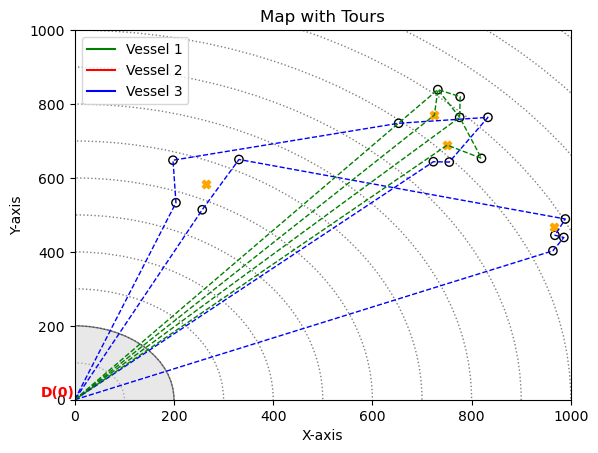

In [341]:
# Create the base map
ax = show_the_map(problem)

# Plot all trips on the map
ax = plot_all_trips(ax, processed_best, problem)

# Display the combined plot
plt.show()

[0, 5, 18, 18, 20, 4, 0]


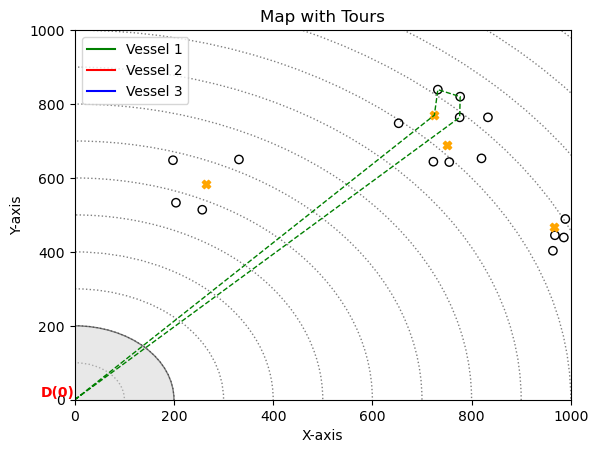

In [342]:
bx = show_the_map(problem)

bx = plot_some_trips(bx, processed_best, problem,1)

plt.show()

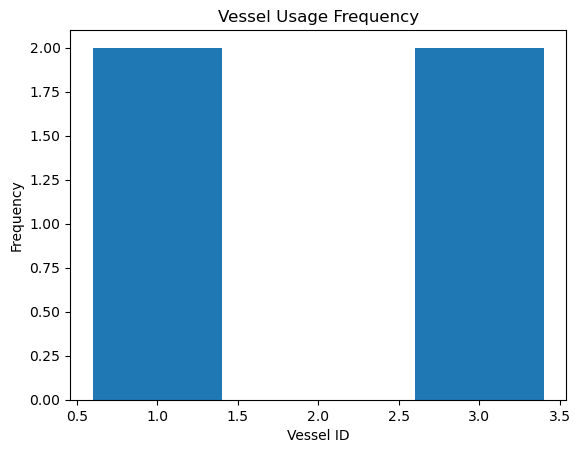

In [343]:
show_vessel_distribution(processed_best)

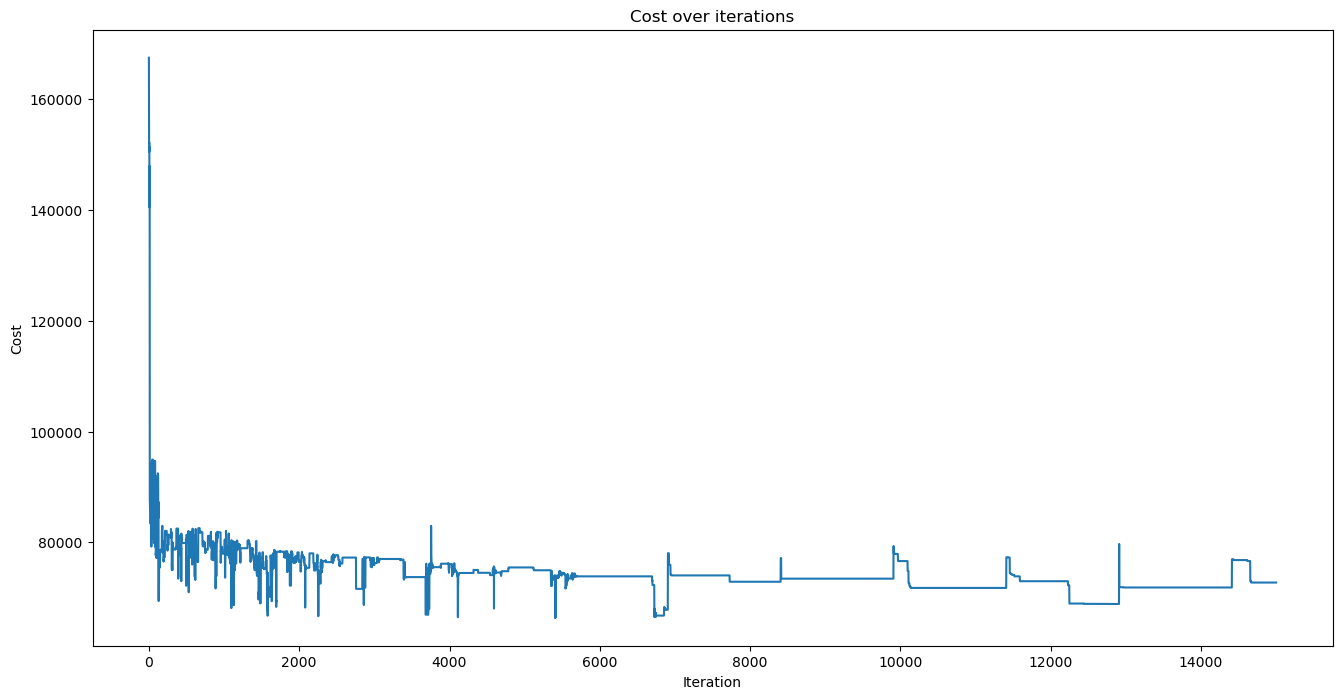

<Axes: title={'center': 'Cost over iterations'}, xlabel='Iteration', ylabel='Cost'>

In [344]:
plot_costs(costs)

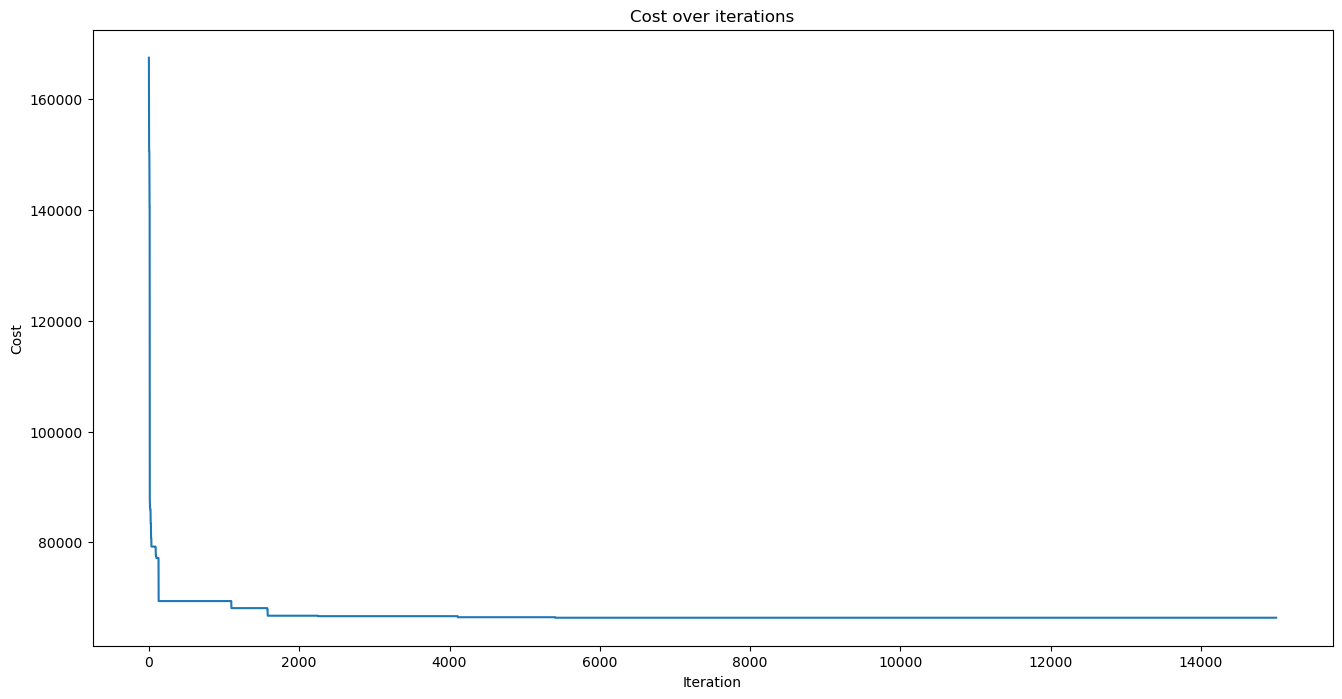

<Axes: title={'center': 'Cost over iterations'}, xlabel='Iteration', ylabel='Cost'>

In [345]:
plot_costs(best_costs)

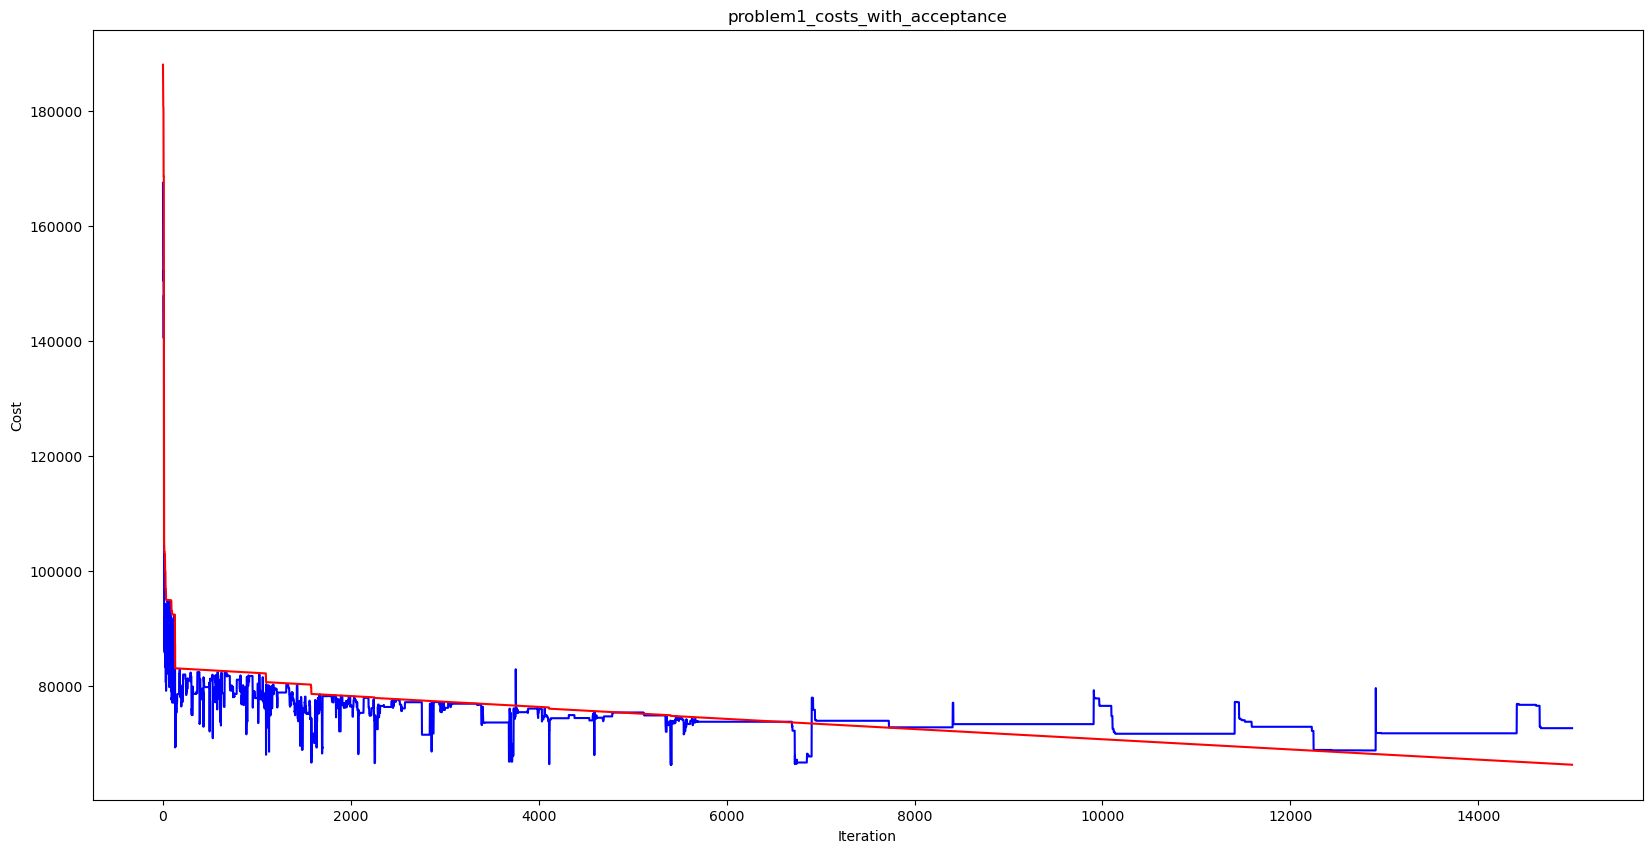

<Axes: title={'center': 'problem1_costs_with_acceptance'}, xlabel='Iteration', ylabel='Cost'>

In [346]:
multiple_plots(costs,accept_list,title='problem1_costs_with_acceptance')

15000
y = 0.00x + -1.89


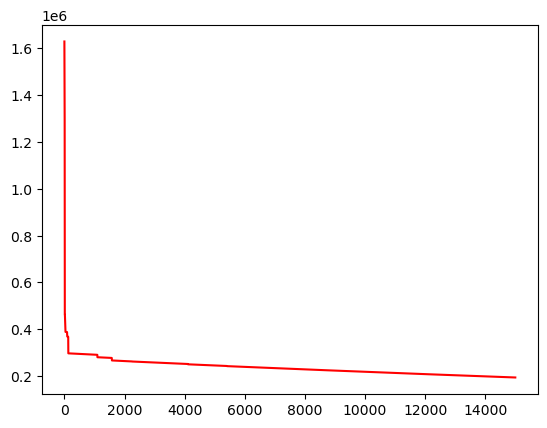

In [347]:
test = accept_list

print(len(accept_list))

coefficients = np.polyfit(range(len(test)), test,2)
line = np.poly1d(coefficients)
plt.plot(range(len(test)), line(test), 'r-')
# Create the equation string
equation = f'y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}'
print(equation)

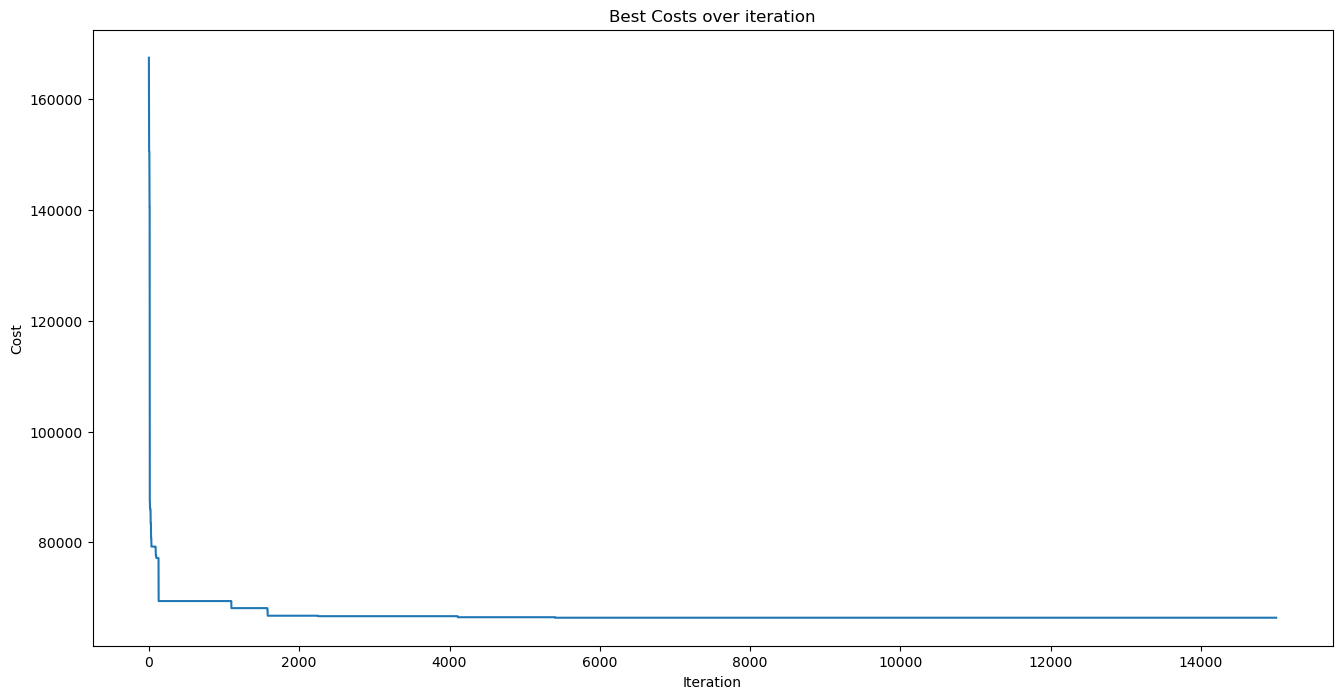

<Axes: title={'center': 'Best Costs over iteration'}, xlabel='Iteration', ylabel='Cost'>

In [348]:
plot_costs(best_costs,title='Best Costs over iteration')

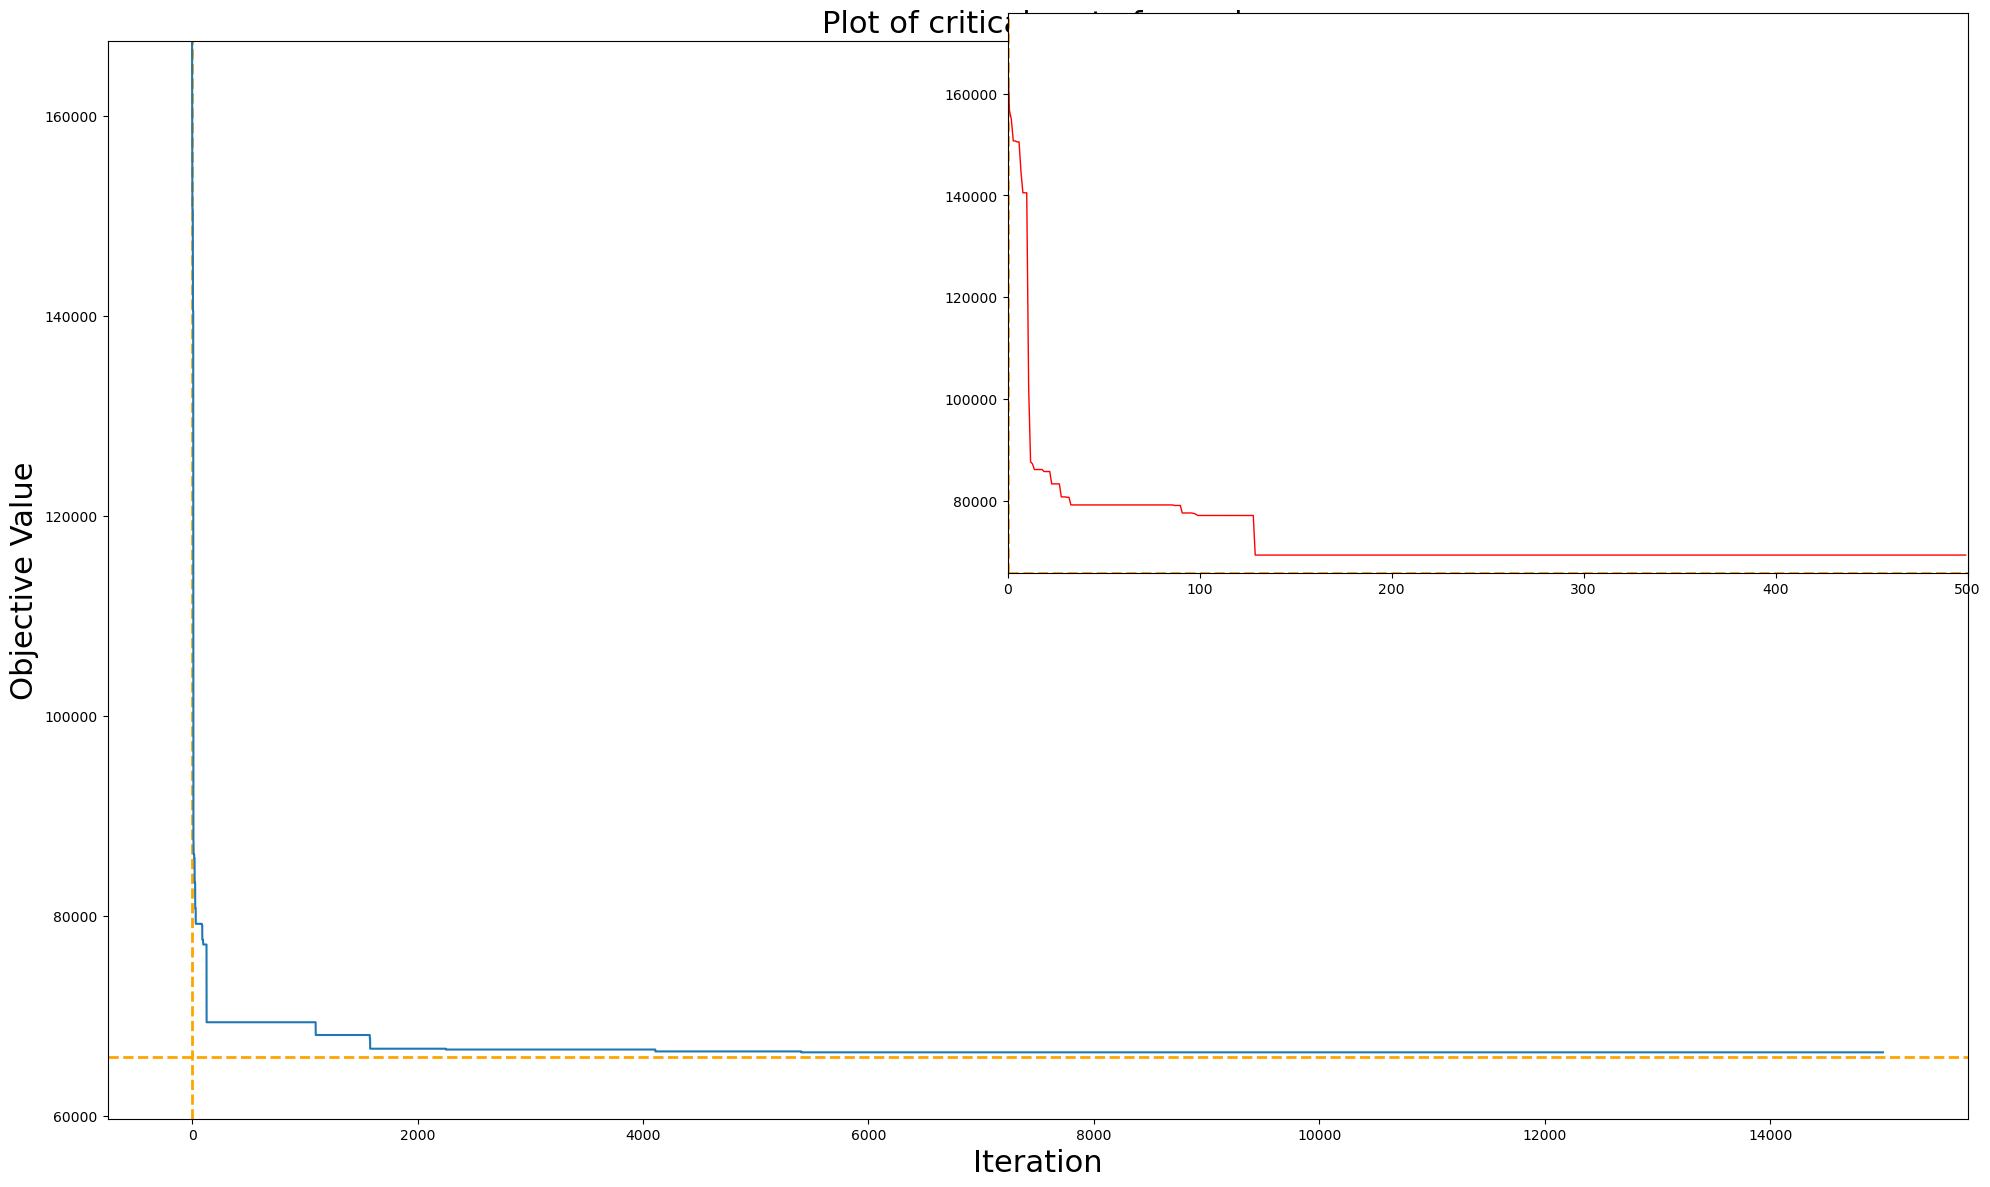

In [349]:
zoomed_plot_(best_costs,0,500)

In [354]:
print([x.__name__ for x in operators])

['random_remove_greedy_insert', 'largest_trip_remove_greedy_insert', 'similarity_removal_greedy_insert', 'worst_removal_greedy_insert', 'smallest_trip_removal_greedy_insert', 'random_remove_kregret_insert', 'largest_trip_remove_kregret_insert', 'similarity_removal_kregret_insert', 'worst_removal_kregret_insert', 'smallest_trip_removal_kregret_insert', 'clustering_removal_kncs_greedy_insert', 'clustering_removal_krd_greedy_insert', 'clustering_removal_kncs_kregret_insert', 'clustering_removal_krd_kregret_insert']


['smallest_trip_removal_kregret_insert']


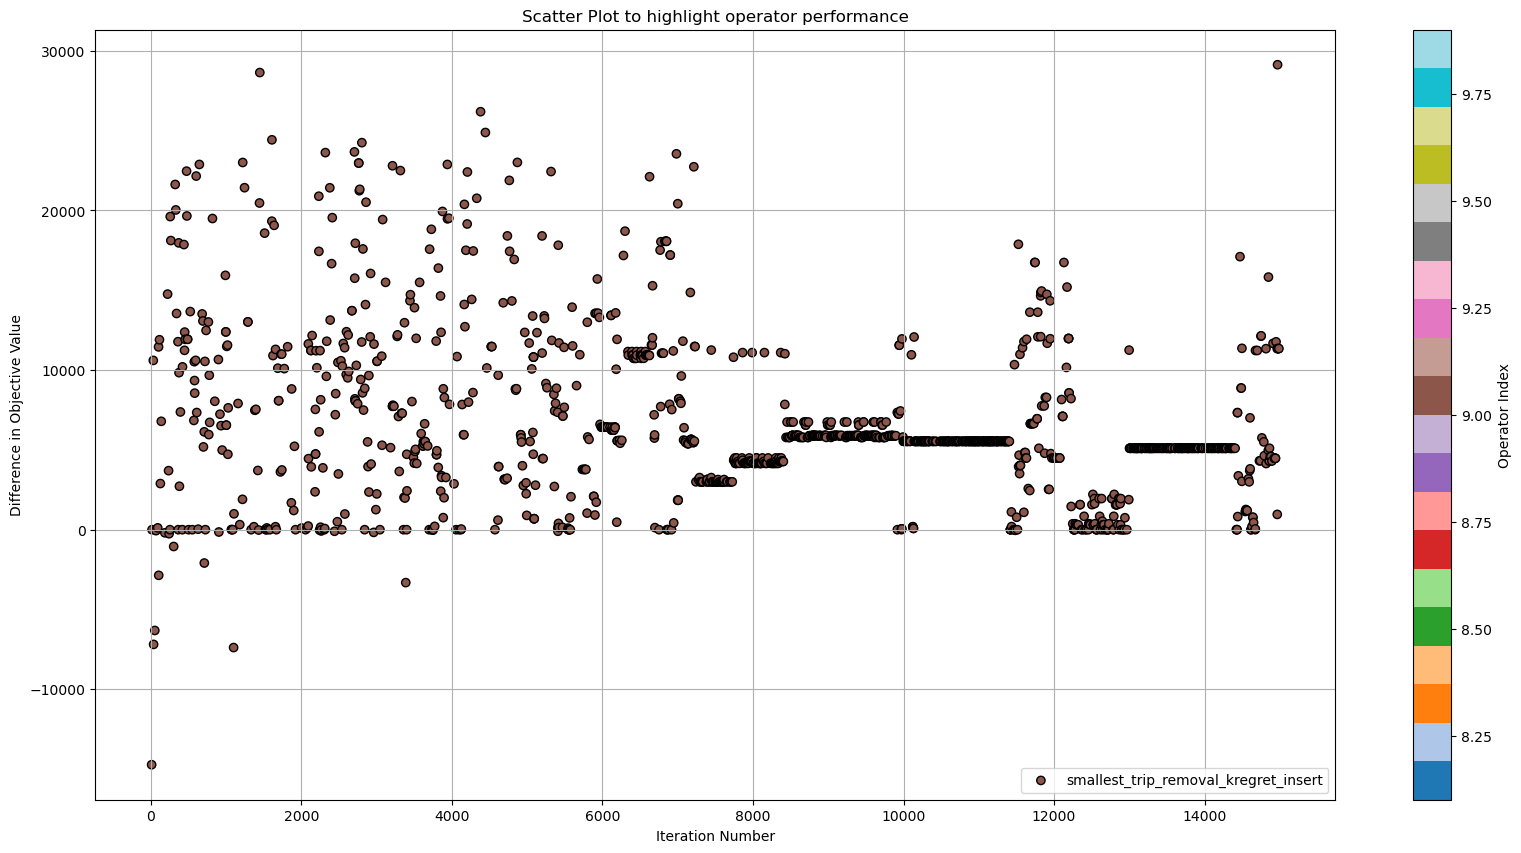

In [370]:
operators_scatter(deltas,operators,highlight=[9])

In [226]:
all_weights[-1]

[0.1955884549149326,
 0.1982474618017591,
 0.1714520649838934,
 0.19827254842474823,
 0.1967826634237395,
 0.17360816614855698,
 0.18700095026681854,
 0.10853256441962253,
 0.19826442631648167,
 0.19113958818833643,
 5.2367352733921624e-23,
 2.3475456551785917e-26,
 2.0186125345513562e-29,
 6.572698617095717e-30]

In [227]:
s = 0
for w in all_weights[-1]:
    w = w/sum(all_weights[-1])
    s += w
print(s)

1.0


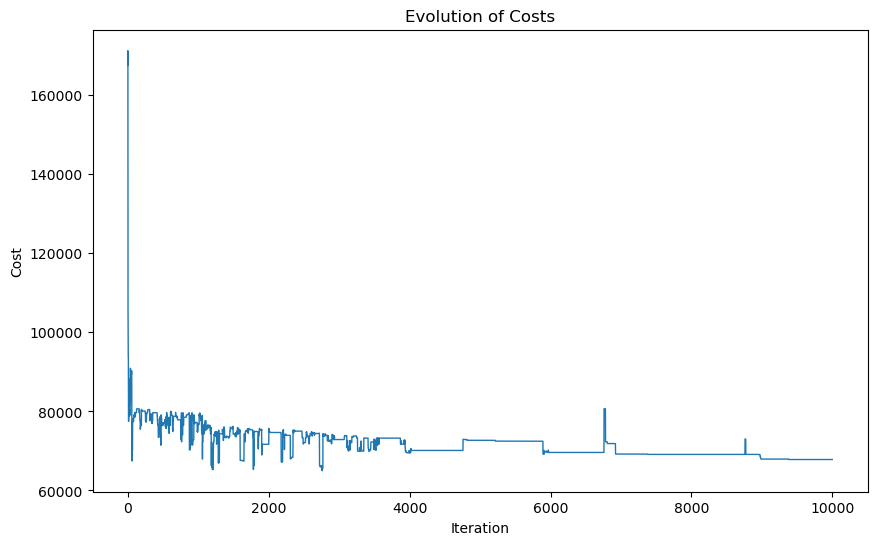

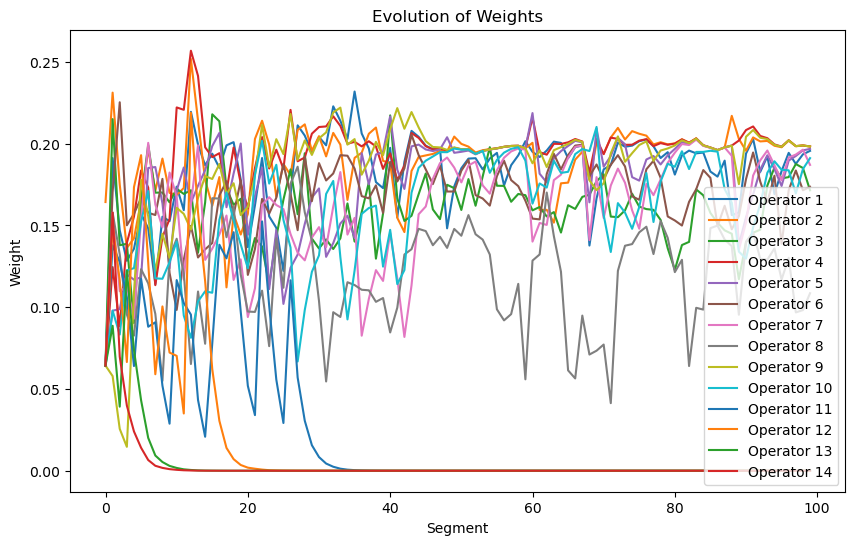

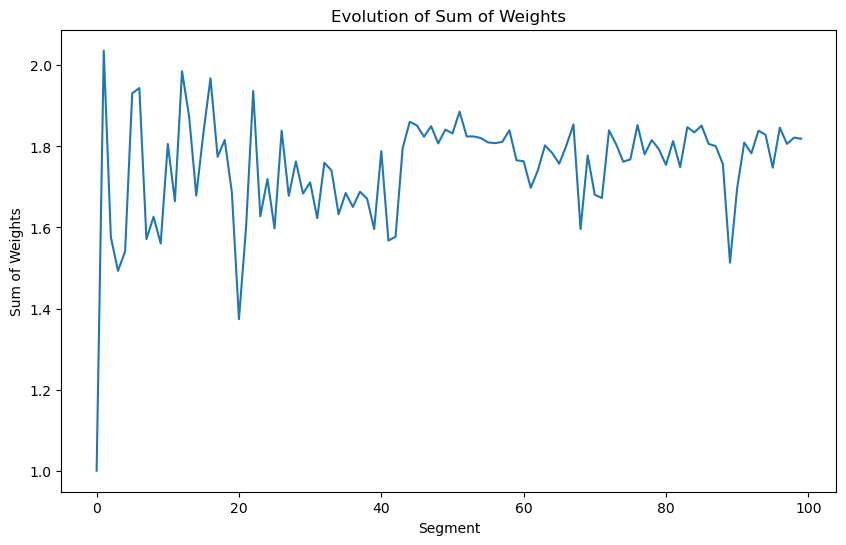

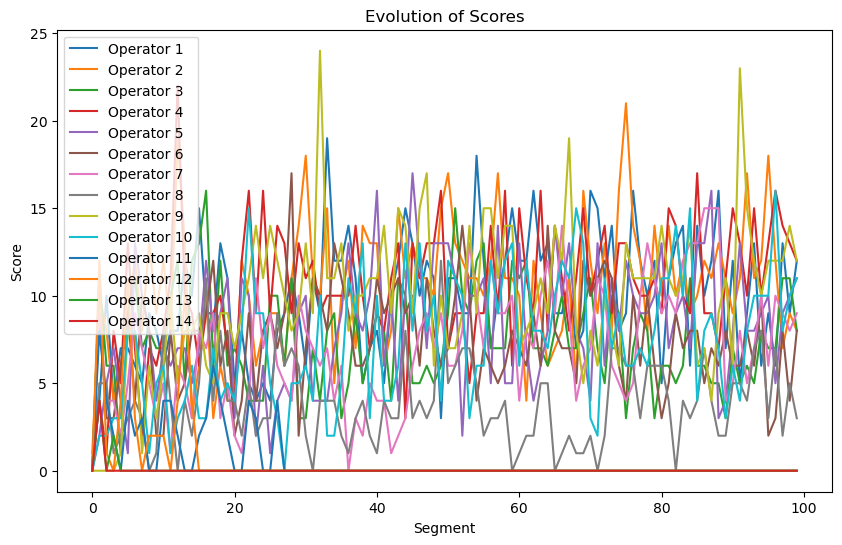

In [228]:
plot_output_lists(costs,all_weights,all_scores)

In [9]:
def multiple_ALNS_runs(problem,operators,n_runs):
    best_solution = 0
    best_cost = float('inf')
    best_run = []
    best_run_best_costs = []
    cost_lists = []
    best_costs_lists = []
    final_improve = []
    avg_cost = []
    t0 = time.time()
    for i in range(n_runs):
        print(f'Starting run {i+1}')
        initial = initial_solution(problem,problem['N_trips'])
        _,processed_best,cost,new_best,costs,_,_,_,final_improvement,_,_, _ = ALNS(initial,problem,operators,5000)
        cost_lists.append(costs)
        best_costs_lists.append(new_best)
        final_improve.append(final_improvement)
        avg_cost.append(cost)
        if cost<best_cost:
            best_solution = processed_best
            best_cost = cost
            best_run = costs
            best_run_best_costs = new_best
            
        
    t1 = time.time()-t0
    print(f'Finished {n_runs} runs in {t1:.2f} seconds')
    avg_cost = sum(avg_cost)/n_runs
    final_improve = sum(final_improve)/n_runs
    cost_lists = [sum(values) / len(values) for values in zip(*cost_lists)]
    best_costs_lists = [sum(values) / len(values) for values in zip(*best_costs_lists)]
    
    time_per_run = t1/n_runs
    
    
    return best_solution,avg_cost,best_cost,best_run,best_run_best_costs,best_costs_lists,cost_lists,final_improve,time_per_run

In [10]:
def RunAll(problems,operators,n_runs):
    results = {}
    for i in range(len(problems)):
        problem = problems[i]
        print(f'Starting problem {i+1}')
        best_solution,avg_cost,best_cost,best_run,best_run_best_costs,best_costs_lists,cost_lists,final_improve,time_per_run = multiple_ALNS_runs(problem,operators,n_runs)
        results[i+1]=(best_solution,avg_cost,best_cost,best_run,best_run_best_costs,best_costs_lists,cost_lists,final_improve,time_per_run)
    return results

In [ ]:
results = RunAll(problems,operators,10)

In [3]:
keys = results.keys()

print(keys)

NameError: name 'results' is not defined

In [4]:
#with open('5k_n10_all30.pkl', 'wb') as file:
#    pickle.dump(results, file)

with open('/Users/simonhusebo/Dokumenter/MASTERS CODE/results/5k_n10_all30.pkl', 'rb') as file:
    results = pickle.load(file)
keys = results.keys()

In [5]:
instance = 30
problem = problems[instance-1]
processed_best = results[instance][0]
cost = results[instance][3]
best_cost = results[instance][4]
avg_best = results[instance][5]
print(avg_best)


[3246000.0, 3058886.7149999994, 2920538.6595, 2906556.2705000006, 2591794.9795, 2492165.151, 2480349.592, 2463481.743, 2449806.0204999996, 2435946.009, 2417035.914, 2400229.528, 2382135.766, 2359048.154, 2350837.1119999997, 2333379.8099999996, 2321390.6515, 2313089.5225, 2298703.4325, 2285247.3935, 2189553.4345, 2186232.482, 2166959.0345, 2145323.336, 2140070.9469999997, 2137464.431, 2130896.8199999994, 2119704.6829999997, 2107888.0305, 2105244.4390000002, 2093526.2595000002, 2081386.934, 2033792.991, 1929457.424, 1914089.836, 1899722.8195, 1886947.5484999996, 1874890.2585, 1847834.0059999998, 1828195.7349999999, 1817361.0250000004, 1798064.3560000001, 1694571.572, 1689069.5745, 1687742.2314999998, 1687089.9164999998, 1685439.9485000004, 1682306.7215, 1676586.83, 1672194.7610000004, 1669321.7715000003, 1668661.7345000003, 1664092.4280000005, 1658175.0645000003, 1658161.4040000003, 1657231.2655000002, 1656512.3235000002, 1655402.9535, 1654541.698, 1654497.8735000002, 1652154.8790000004,

In [ ]:
a = multiple_plots(cost,avg_best,title=f'Instance {instance}: Best run (blue) Average run (red)')


In [ ]:
zoomed_plot_(cost,0,500,data2=avg_best,save=True,save_name=f'/Users/simonhusebo/Dokumenter/MASTERS CODE/figures/instance{instance}_zoomed.png')

In [65]:
avg_costs = []
plots = []
imps = []
best_costs = []
times = []

keys = list(keys)
for i in range(0,len(keys),5):
    ks = keys[i:i+5]
    costs = sum([results[k][1] for k in ks])/5
    runs = [results[k][5] for k in ks]
    a = [sum(values) / len(values) for values in zip(*runs)]
    imp_iterations = sum([results[k][7] for k in ks])/5
    best_cost = sum([results[k][2] for k in ks])/5
    t = sum([results[k][8] for k in ks])/5
    imps.append(imp_iterations)
    times.append(t)
    best_costs.append(best_cost)    
    avg_costs.append(costs)
    plots.append(a)
    
improvements = calculate_improvement(problems,results,segment=True)
    
    
    

Initial Solution:           [(0, 0), (0, 0), (0, 0), (0, 0), (5, 0), (5, 1), (6, 0), (6, 1), (7, 0), (7, 1), (8, 0), (8, 1), (9, 0), (9, 1), (10, 0), (10, 1), (11, 0), (11, 1), (12, 0), (12, 1), (13, 0), (13, 1), (14, 0), (14, 1), (15, 0), (15, 1), (16, 0), (16, 1), (17, 0), (17, 1), (18, 0), (18, 1), (19, 0), (19, 1), (20, 0), (20, 1)]
Initial Solution:           [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (6, 0), (6, 1), (7, 0), (7, 1), (8, 0), (8, 1), (9, 0), (9, 1), (10, 0), (10, 1), (11, 0), (11, 1), (12, 0), (12, 1), (13, 0), (13, 1), (14, 0), (14, 1), (15, 0), (15, 1), (16, 0), (16, 1), (17, 0), (17, 1), (18, 0), (18, 1), (19, 0), (19, 1), (20, 0), (20, 1), (21, 0), (21, 1), (22, 0), (22, 1), (23, 0), (23, 1), (24, 0), (24, 1), (25, 0), (25, 1), (26, 0), (26, 1), (27, 0), (27, 1), (28, 0), (28, 1), (29, 0), (29, 1), (30, 0), (30, 1), (31, 0), (31, 1), (32, 0), (32, 1), (33, 0), (33, 1), (34, 0), (34, 1), (35, 0), (35, 1)]
Initial Solution:           [(0, 0), (0, 0),

In [66]:
# Assumed variables and problem_types are defined as before
problem_types = ['16\_4\_4', '30\_5\_7', '42\_7\_10', '72\_9\_18', '121\_11\_35', '300\_20\_70']

# Print formatted rows for LaTeX
for index, problem_type in enumerate(problem_types):
    print(f"{problem_type} & {best_costs[index]:,.0f} & {avg_costs[index]:,.0f} & {improvements[index]:.2f}\\% & {imps[index]:,.0f} & {times[index]:,.0f} \\\\")


16\_4\_4 & 76,516 & 78,189 & 60.23\% & 2,158 & 94 \\
30\_5\_7 & 139,389 & 144,295 & 60.65\% & 1,500 & 113 \\
42\_7\_10 & 193,916 & 201,261 & 64.80\% & 1,347 & 138 \\
72\_9\_18 & 331,701 & 343,567 & 58.03\% & 1,270 & 213 \\
121\_11\_35 & 548,141 & 561,856 & 61.69\% & 1,328 & 429 \\
300\_20\_70 & 1,430,128 & 1,471,123 & 57.93\% & 1,119 & 1,801 \\


Problem type: 16_4_4
Best cost: 76516
Average cost: 78189
Average improvement iterations: 2158
Average time per run: 94s
Improvement: 60.23%


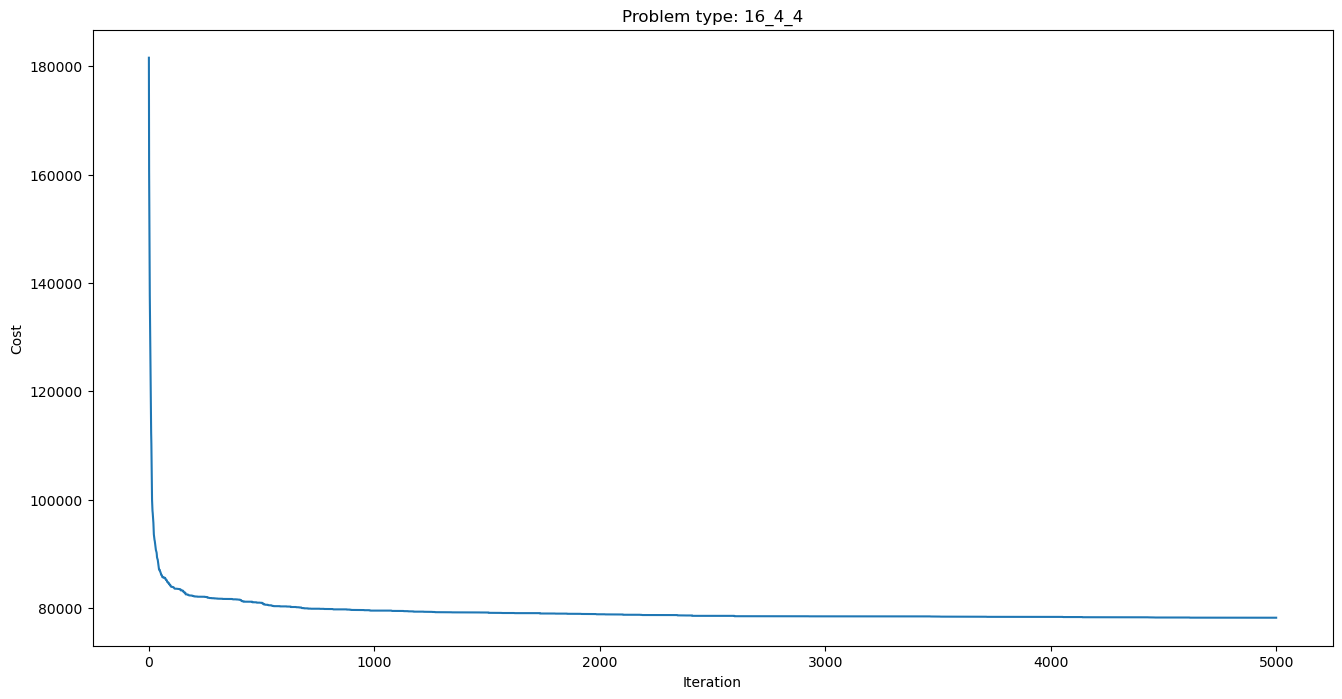

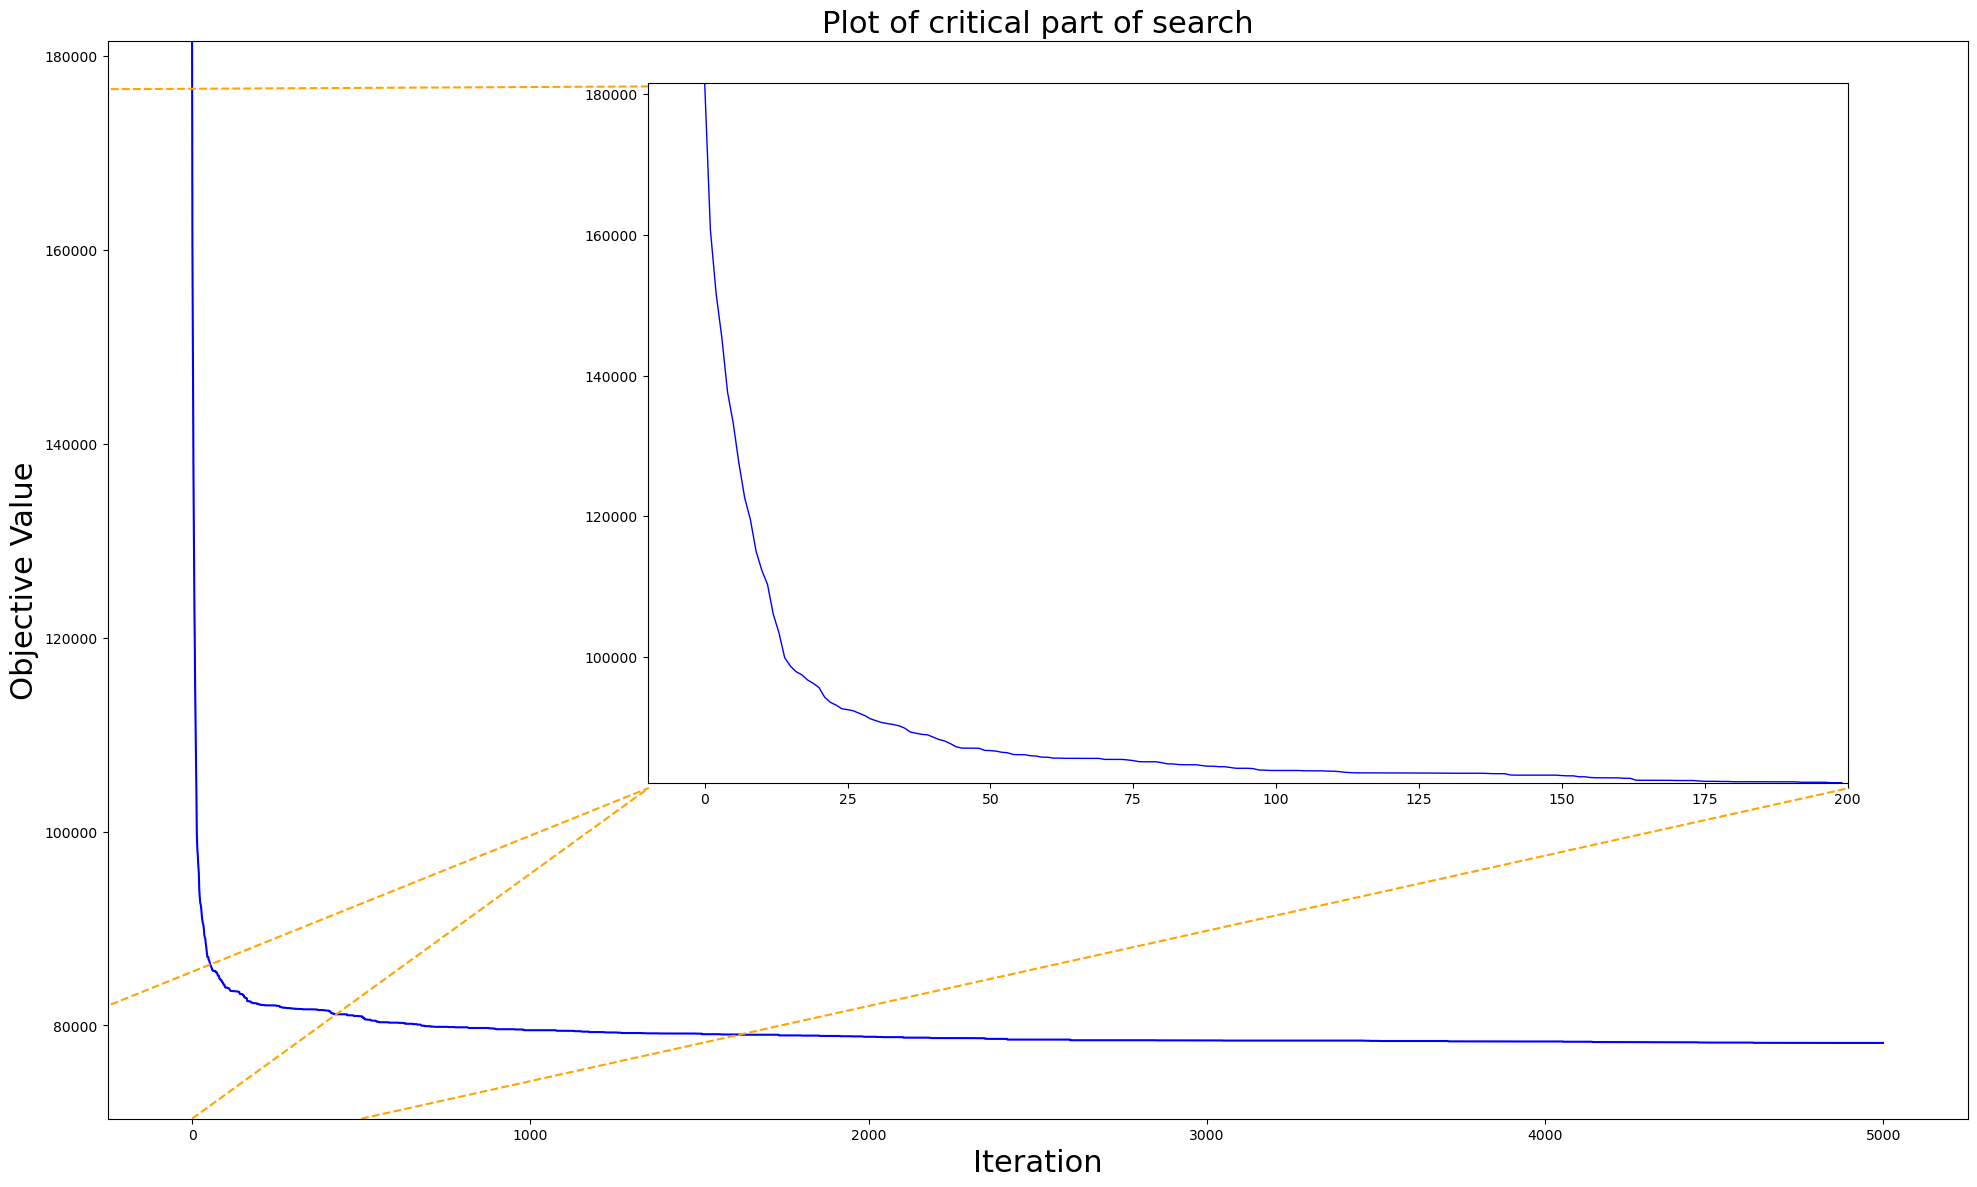

Problem type: 30_5_7
Best cost: 139389
Average cost: 144295
Average improvement iterations: 1500
Average time per run: 113s
Improvement: 60.65%


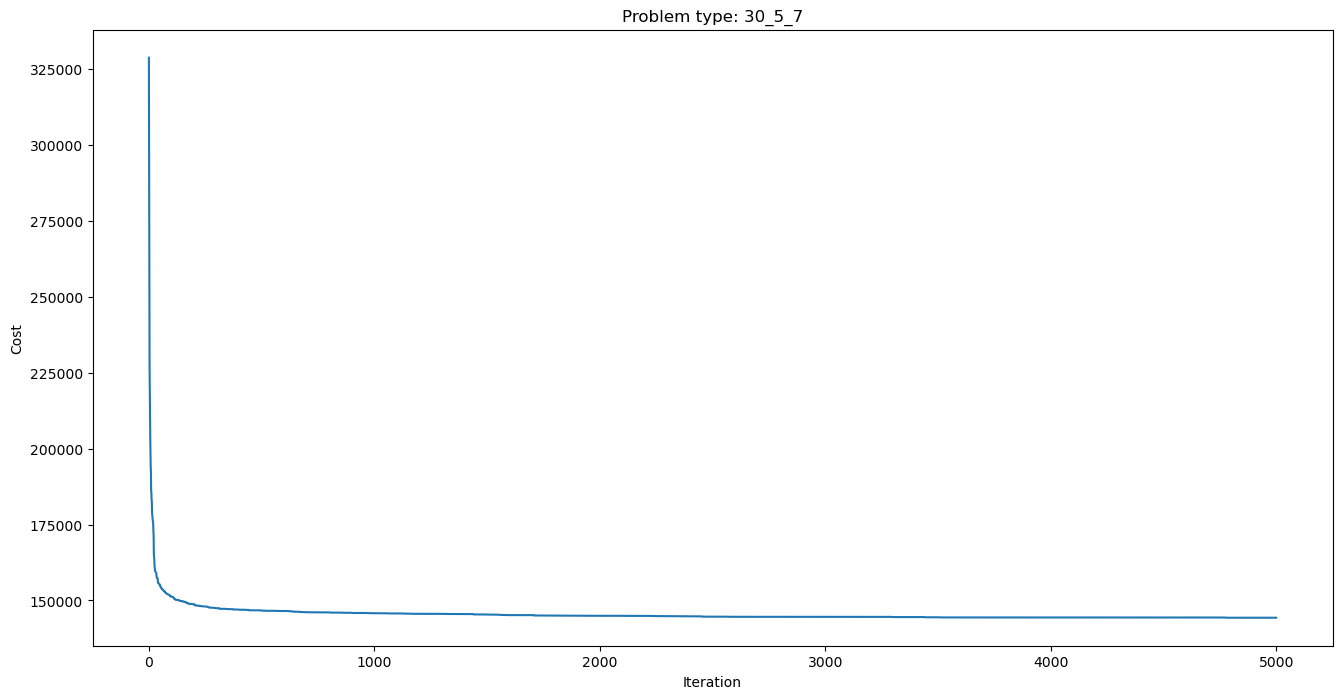

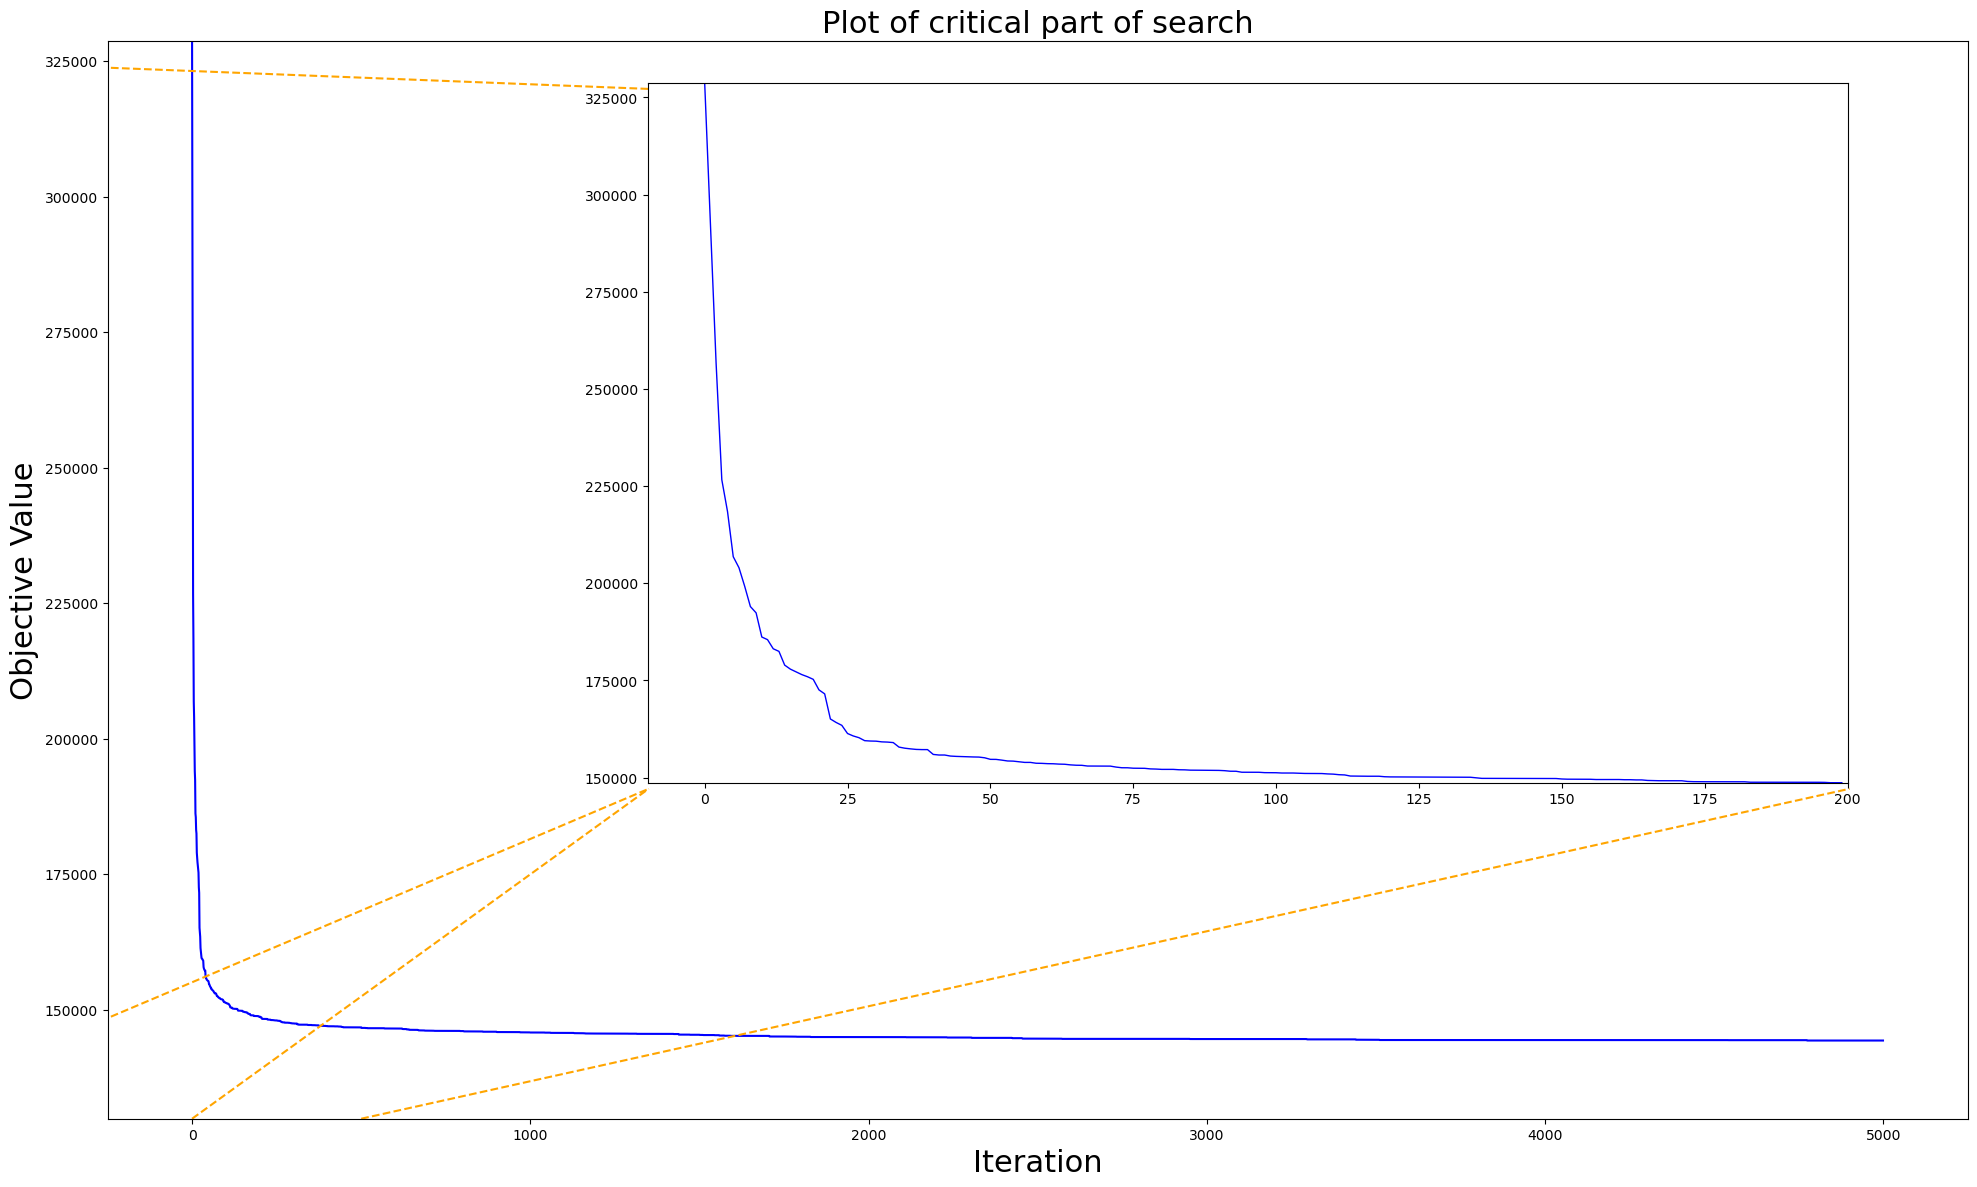

Problem type: 42_7_10
Best cost: 193916
Average cost: 201261
Average improvement iterations: 1347
Average time per run: 138s
Improvement: 64.80%


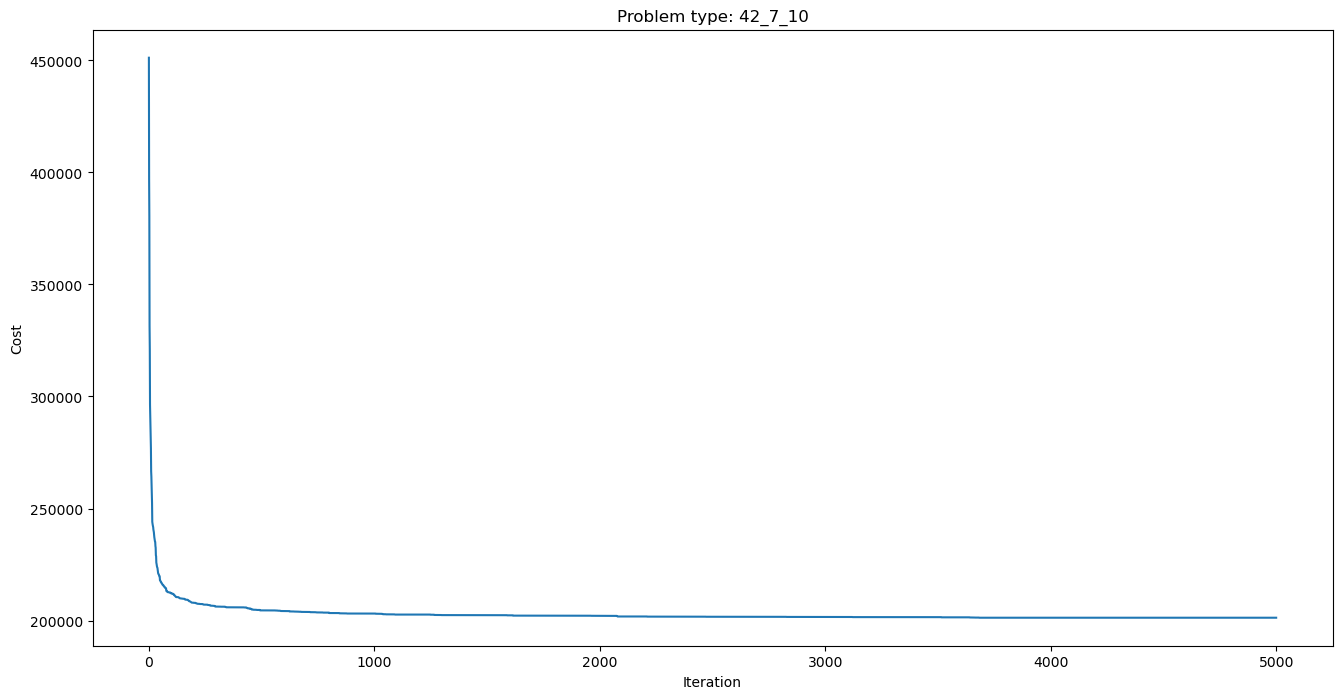

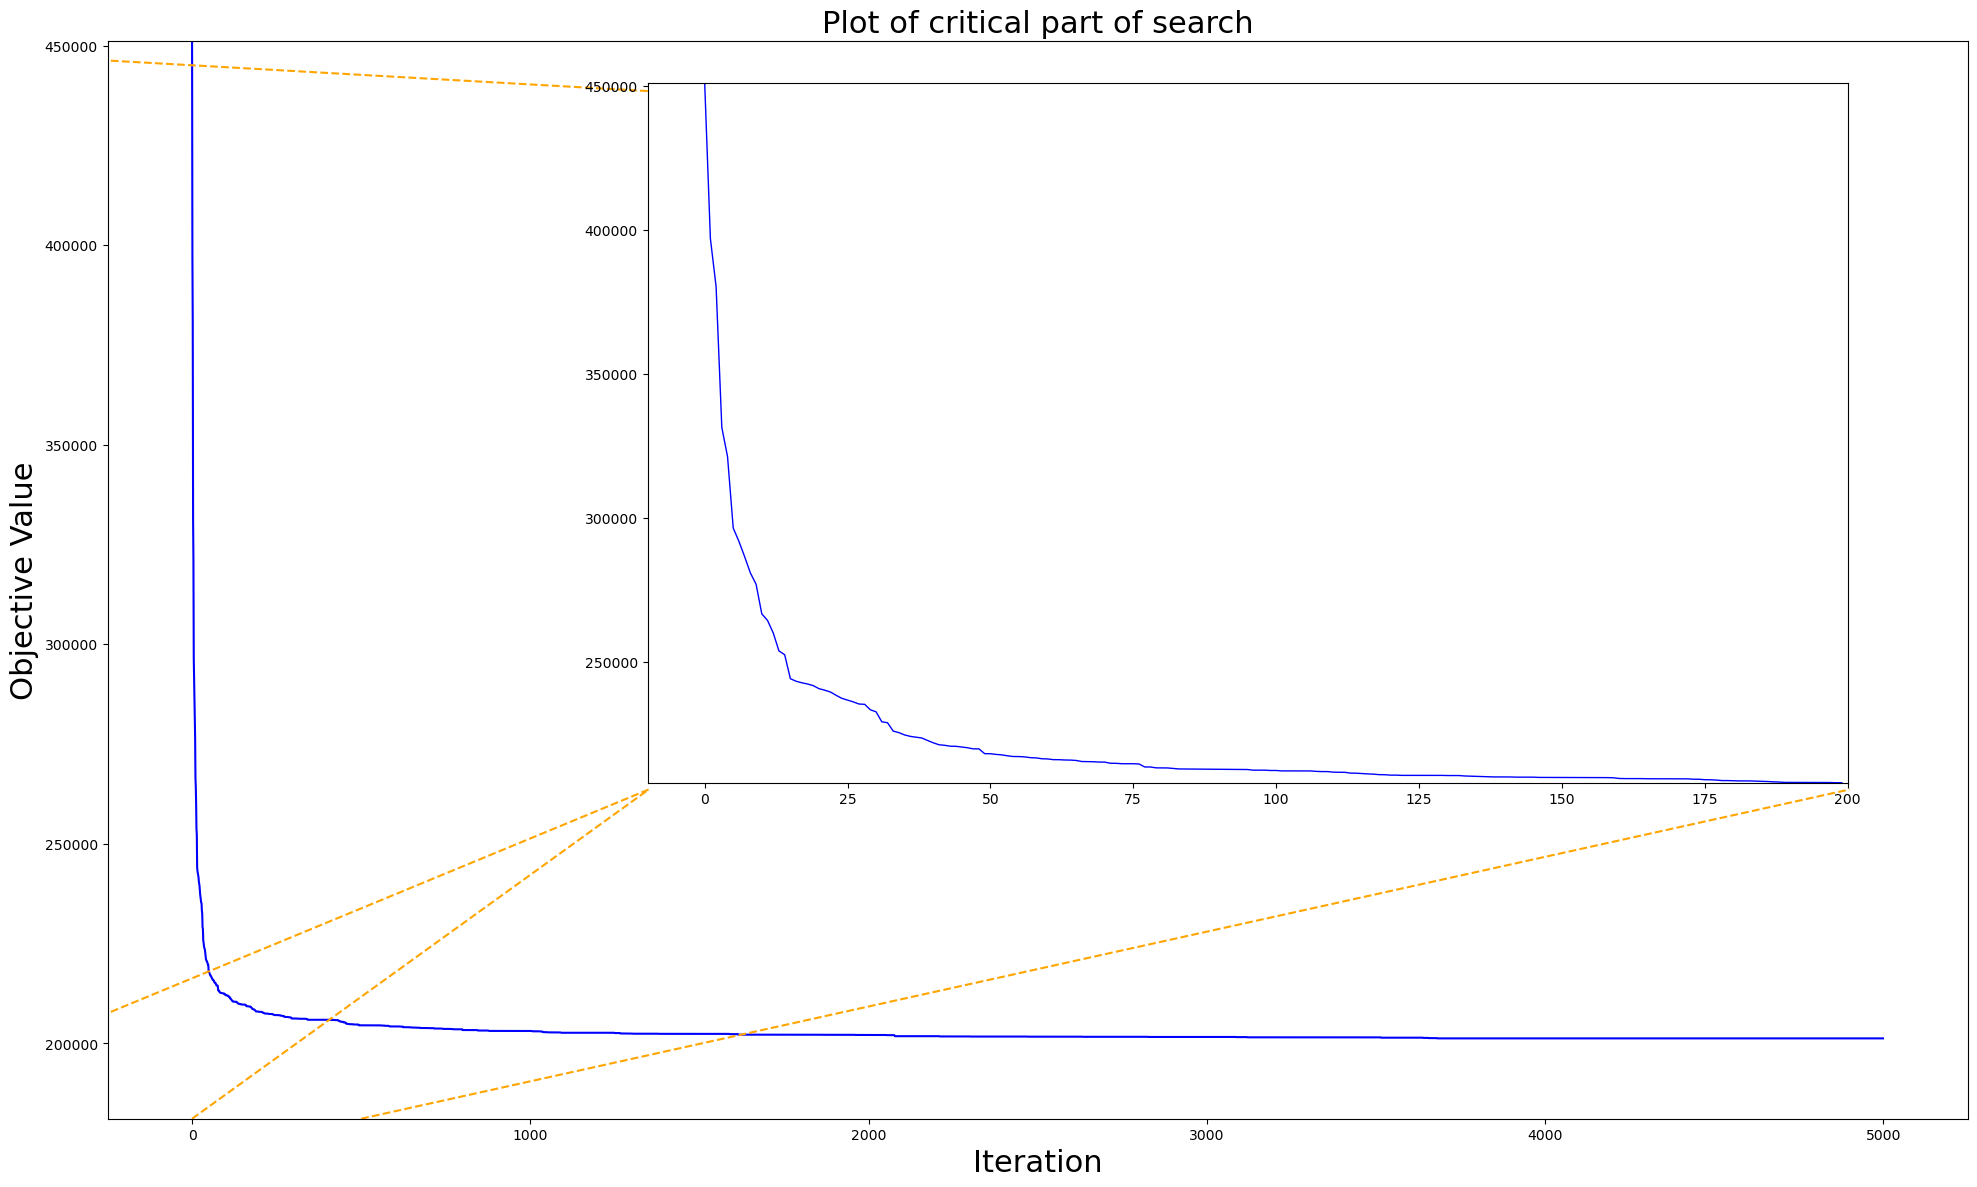

Problem type: 72_9_18
Best cost: 331701
Average cost: 343567
Average improvement iterations: 1270
Average time per run: 213s
Improvement: 58.03%


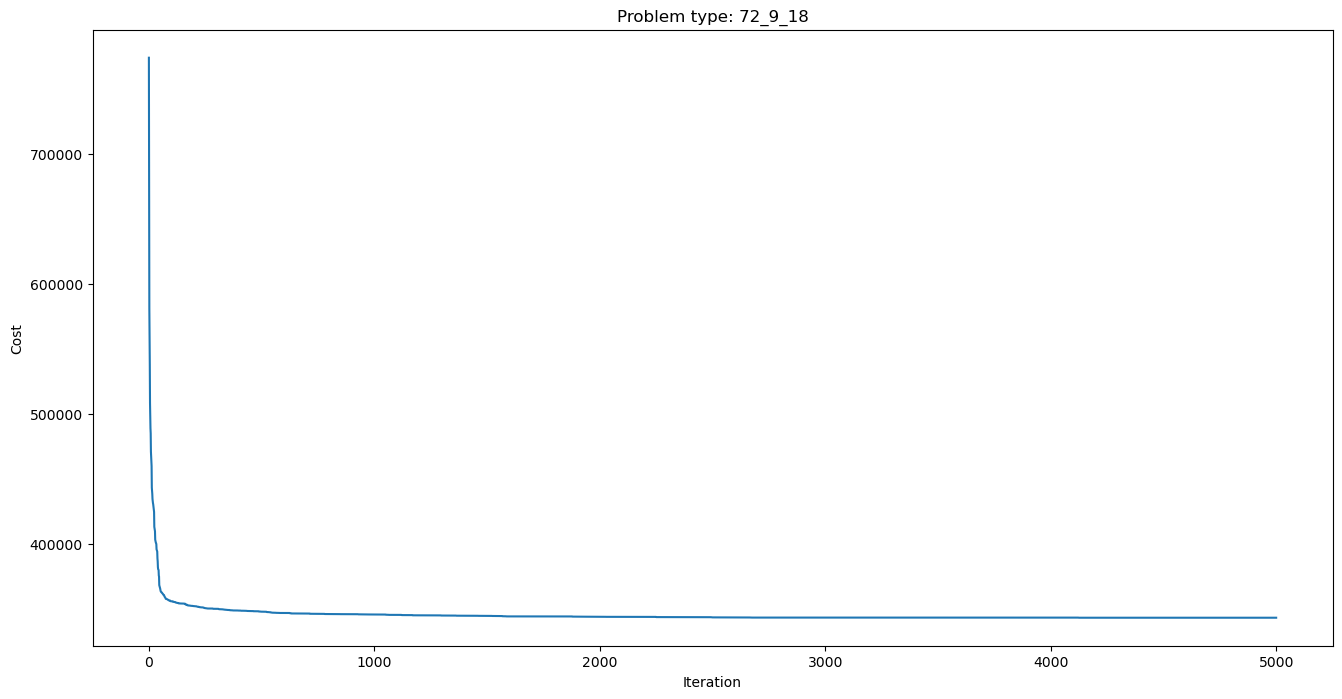

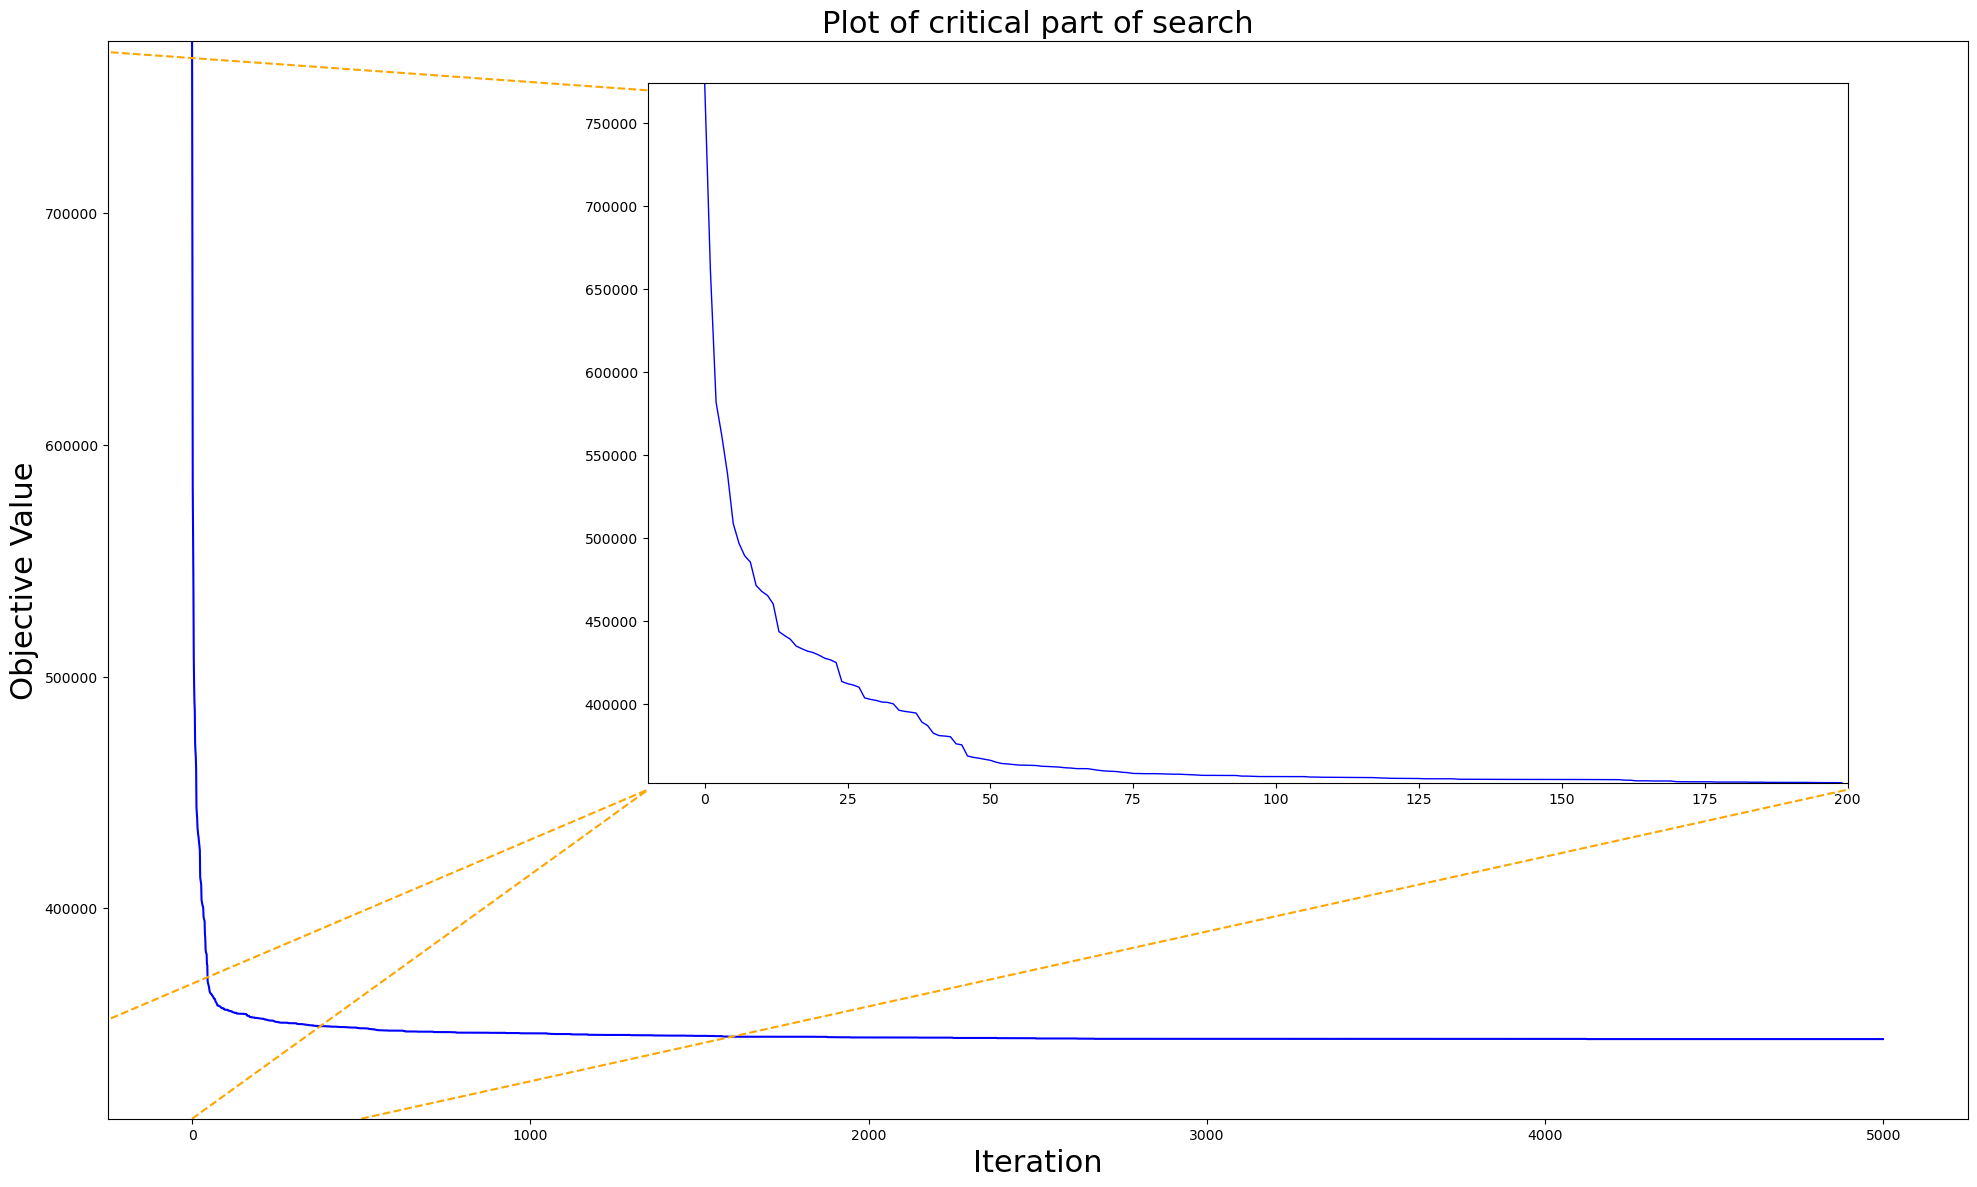

Problem type: 121_11_35
Best cost: 548141
Average cost: 561856
Average improvement iterations: 1328
Average time per run: 429s
Improvement: 61.69%


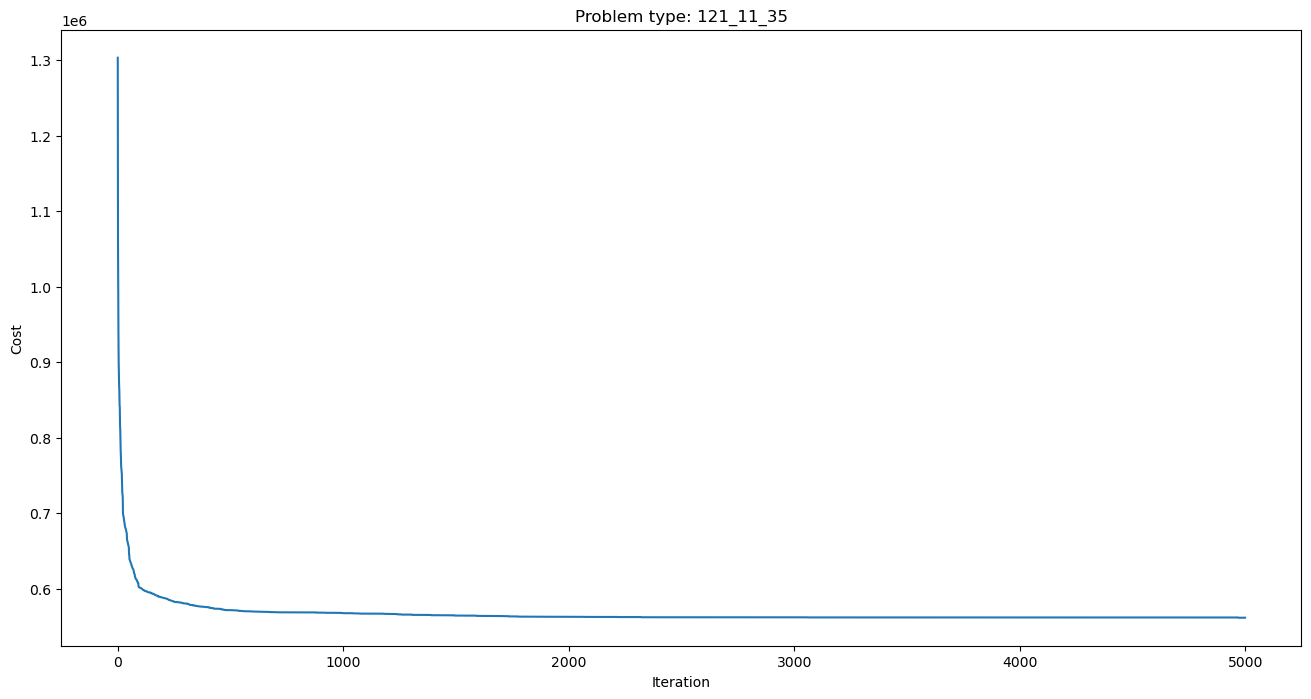

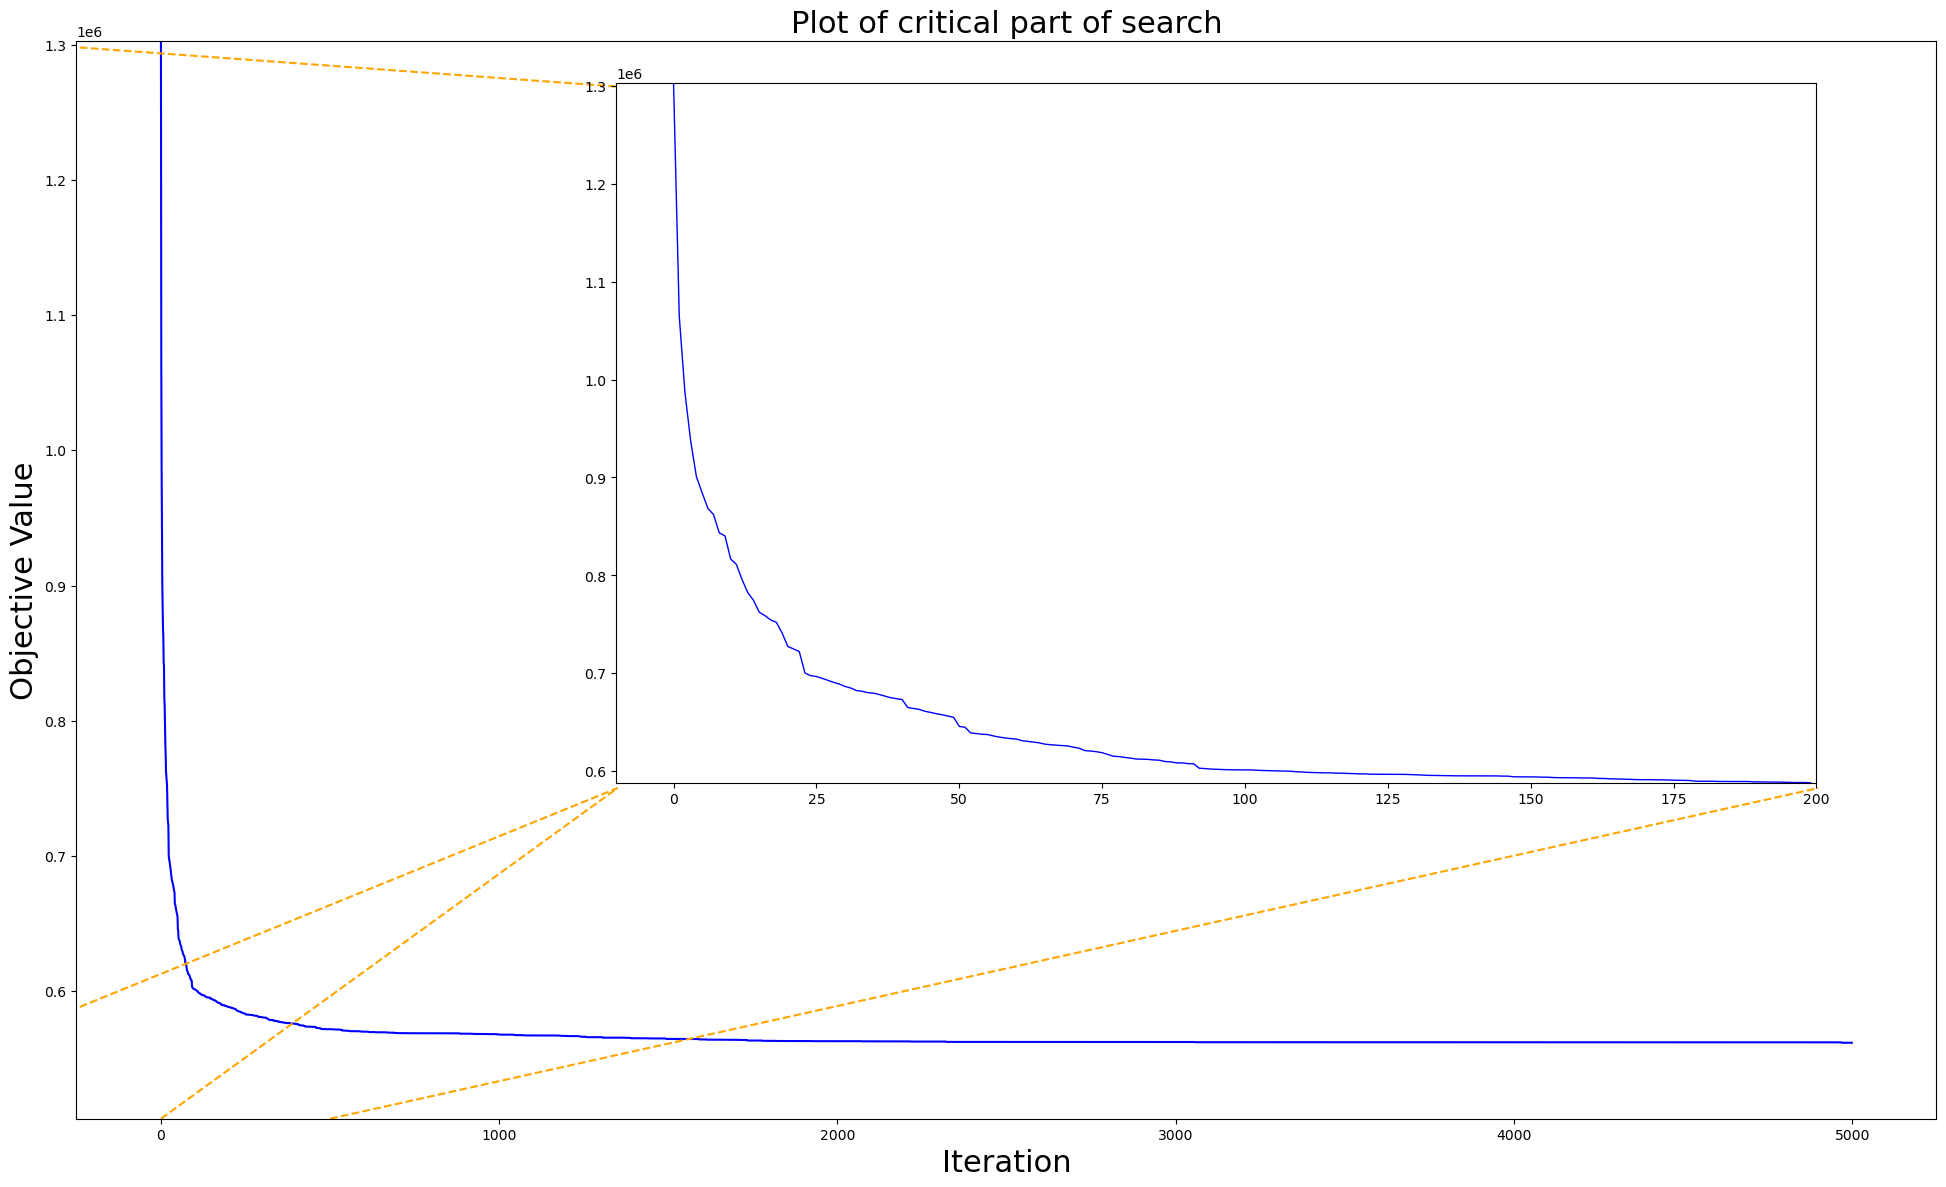

Problem type: 300_20_70
Best cost: 1430128
Average cost: 1471123
Average improvement iterations: 1119
Average time per run: 1801s
Improvement: 57.93%


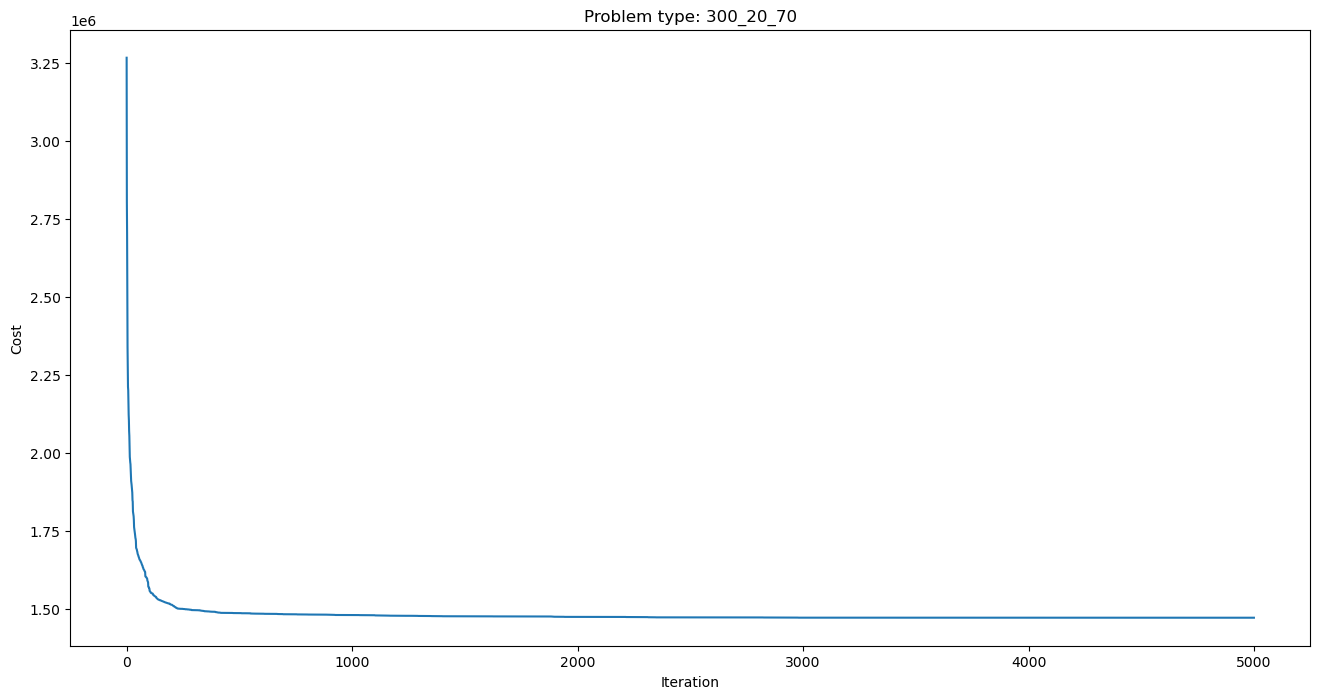

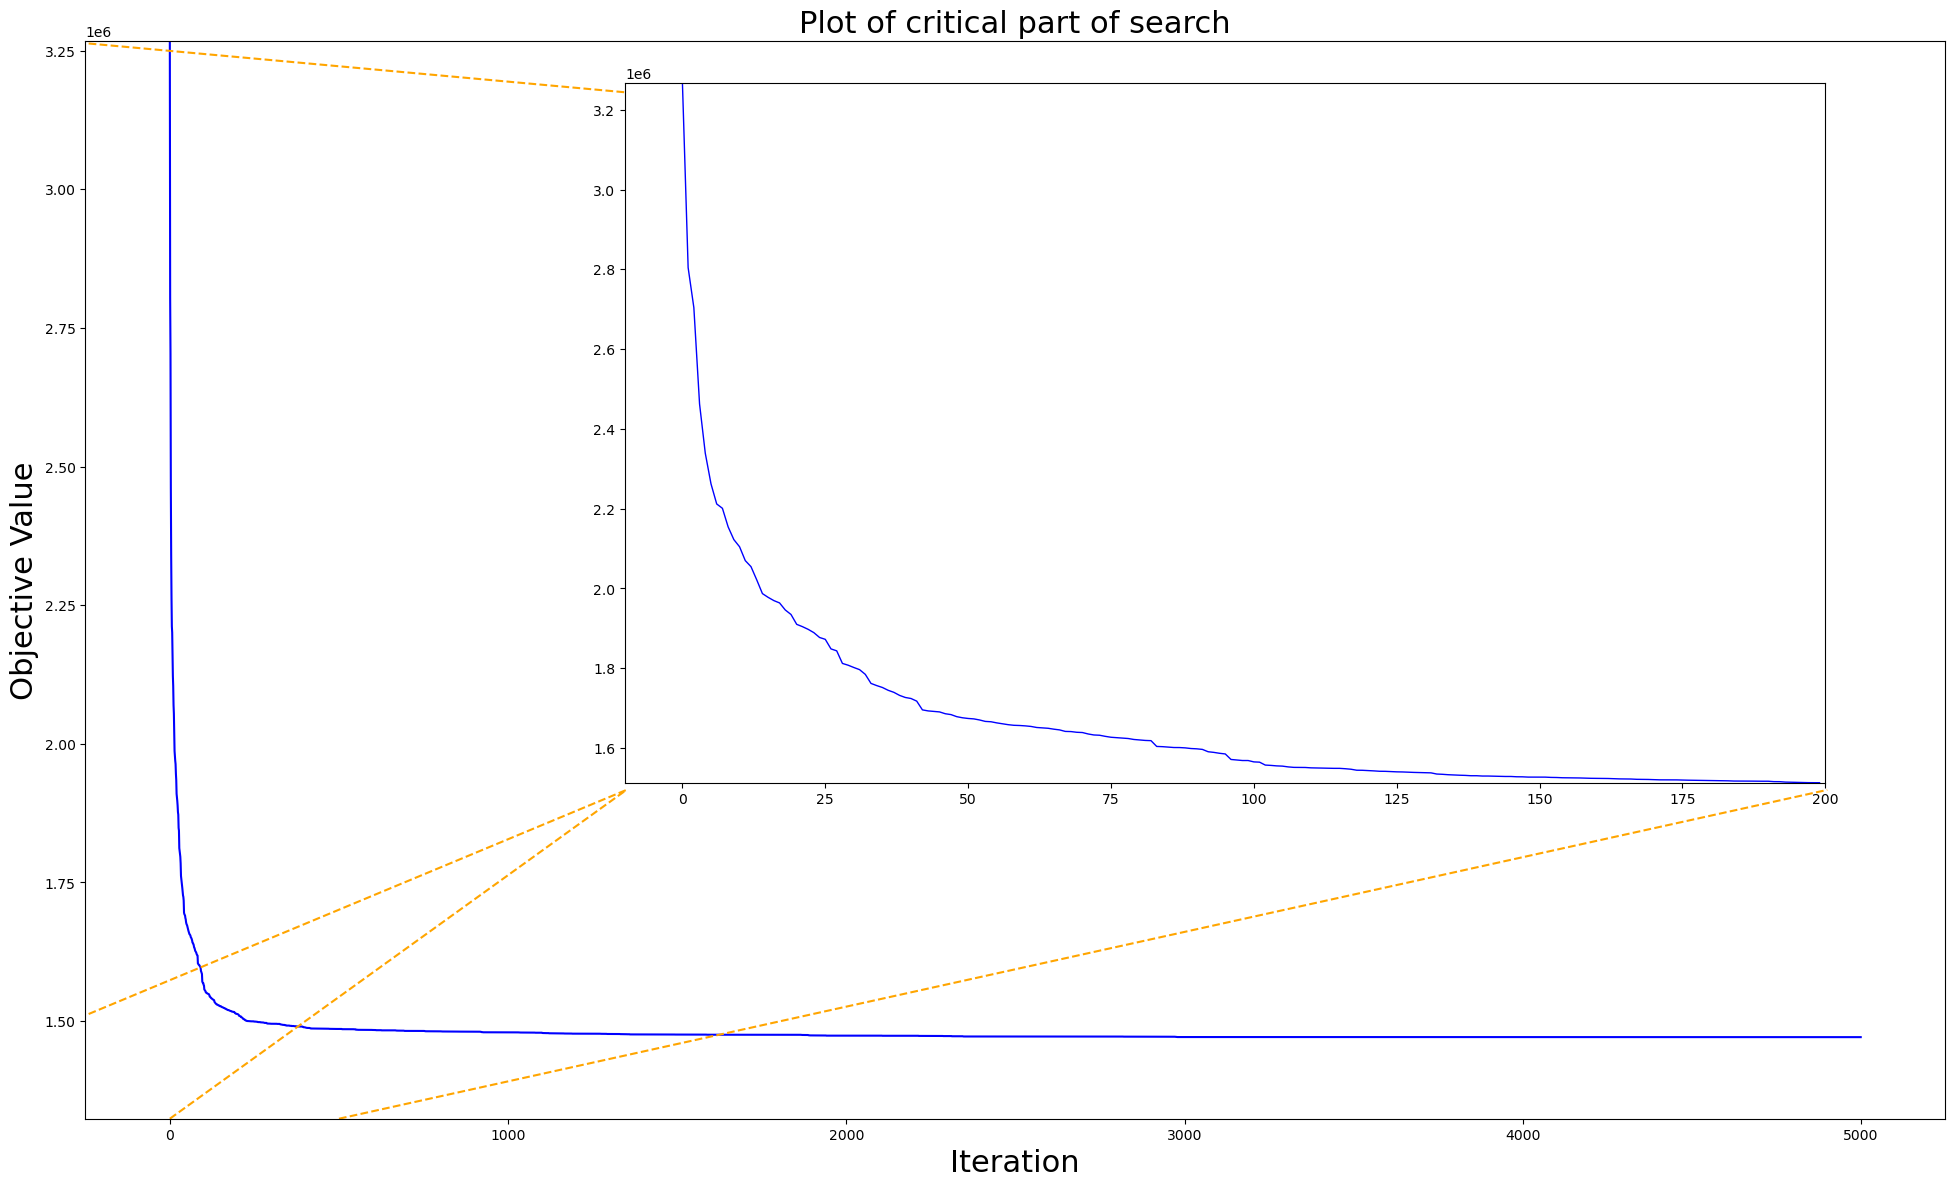

In [17]:
for k in range(6):
    print(f'Problem type: {problem_types[k]}')
    print(f'Best cost: {best_costs[k]:.0f}')
    print(f'Average cost: {avg_costs[k]:.0f}')
    print(f'Average improvement iterations: {imps[k]:.0f}')
    print(f'Average time per run: {times[k]:.0f}s')
    print(f'Improvement: {improvements[k]:.2f}%')
    plot_costs(plots[k],title=f'Problem type: {problem_types[k]}')
    zoomed_plot(plots[k],0,200)
    

In [49]:
instances_per_type = 5

improvements = calculate_improvement(problems,results)
problem_types = ['16\_4\_4', '30\_5\_7', '42\_7\_10', '72\_9\_18', '121\_11\_35', '300\_20\_70']

# Print formatted rows for LaTeX
for key in sorted(results.keys()):
    # Determine problem type and instance number within type
    type_index = (key - 1) // instances_per_type
    instance_number_within_type = (key - 1) % instances_per_type + 1
    problem_label = f"{{{problem_types[type_index]}/{instance_number_within_type}}}"
    
    instance_data = results[key]
    print(f"{problem_label} & {instance_data[2]:,.0f} & {instance_data[1]:,.0f} & {improvements[key-1]:.2f}\\% & {instance_data[7]:,.0f} & {instance_data[8]:,.0f} \\\\")

Initial Solution:           [(0, 0), (0, 0), (0, 0), (0, 0), (5, 0), (5, 1), (6, 0), (6, 1), (7, 0), (7, 1), (8, 0), (8, 1), (9, 0), (9, 1), (10, 0), (10, 1), (11, 0), (11, 1), (12, 0), (12, 1), (13, 0), (13, 1), (14, 0), (14, 1), (15, 0), (15, 1), (16, 0), (16, 1), (17, 0), (17, 1), (18, 0), (18, 1), (19, 0), (19, 1), (20, 0), (20, 1)]
Initial Solution:           [(0, 0), (0, 0), (0, 0), (0, 0), (5, 0), (5, 1), (6, 0), (6, 1), (7, 0), (7, 1), (8, 0), (8, 1), (9, 0), (9, 1), (10, 0), (10, 1), (11, 0), (11, 1), (12, 0), (12, 1), (13, 0), (13, 1), (14, 0), (14, 1), (15, 0), (15, 1), (16, 0), (16, 1), (17, 0), (17, 1), (18, 0), (18, 1), (19, 0), (19, 1), (20, 0), (20, 1)]
Initial Solution:           [(0, 0), (0, 0), (0, 0), (0, 0), (5, 0), (5, 1), (6, 0), (6, 1), (7, 0), (7, 1), (8, 0), (8, 1), (9, 0), (9, 1), (10, 0), (10, 1), (11, 0), (11, 1), (12, 0), (12, 1), (13, 0), (13, 1), (14, 0), (14, 1), (15, 0), (15, 1), (16, 0), (16, 1), (17, 0), (17, 1), (18, 0), (18, 1), (19, 0), (19, 1), (

In [ ]:
for key in keys:
    #results[i+1]=(best_solution,avg_cost,best_cost,best_run,best_run_best_costs,best_costs_lists,cost_lists,final_improve,time_per_run)
    print(f'Problem {key}')
    print(f'Average cost: {results[key][1]}')
    print(f'Best cost: {results[key][2]}')
    print(f'Final improvement: {results[key][7]}')
    print(f'Average time: {results[key][8]}')
    plot_costs(results[key][5],title=f'Problem {key} costs')
    plot_costs(results[key][3],title=f'Problem {key} best run')
    multiple_plots(results[key][4],results[key][5],title=f'Problem {key} average best costs (run) with best run (blue)')
    print('\n')

In [56]:
def initial_costs(problems,segment = False):
    if segment:
        idx = range(1,len(problems),5)
    else:
        idx = range(len(problems))
        
    costs = []
    for i in idx:
        problem = problems[i]
        initial = initial_solution(problem,problem['N_trips'])
        cost = objective_function(initial,problem)
        costs.append(cost)
        
    return costs

def best_cost_in_segment(results):
    costs = []
    for i in range(1,len(keys)+1,5):
        ks = keys[i:i+5]
        best_cost = min([results[k][2] for k in ks])
        costs.append(best_cost)
    
    return costs

In [63]:
def calculate_improvement(problems, results,segment = False):
    base_costs = initial_costs(problems,segment)
    
    if segment:
        c = best_cost_in_segment(results)
        
    else:
        c = [results[k][2] for k in keys]
        
    improvements = []
    i=1
    for base_cost, best_cost in zip(base_costs, c):
        improvement = ((base_cost - best_cost) / base_cost) * 100
        improvements.append(improvement)
        i+=1
    return improvements


In [64]:
calculate_improvement(problems,results,segment=True)

Initial Solution:           [(0, 0), (0, 0), (0, 0), (0, 0), (5, 0), (5, 1), (6, 0), (6, 1), (7, 0), (7, 1), (8, 0), (8, 1), (9, 0), (9, 1), (10, 0), (10, 1), (11, 0), (11, 1), (12, 0), (12, 1), (13, 0), (13, 1), (14, 0), (14, 1), (15, 0), (15, 1), (16, 0), (16, 1), (17, 0), (17, 1), (18, 0), (18, 1), (19, 0), (19, 1), (20, 0), (20, 1)]
Initial Solution:           [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (6, 0), (6, 1), (7, 0), (7, 1), (8, 0), (8, 1), (9, 0), (9, 1), (10, 0), (10, 1), (11, 0), (11, 1), (12, 0), (12, 1), (13, 0), (13, 1), (14, 0), (14, 1), (15, 0), (15, 1), (16, 0), (16, 1), (17, 0), (17, 1), (18, 0), (18, 1), (19, 0), (19, 1), (20, 0), (20, 1), (21, 0), (21, 1), (22, 0), (22, 1), (23, 0), (23, 1), (24, 0), (24, 1), (25, 0), (25, 1), (26, 0), (26, 1), (27, 0), (27, 1), (28, 0), (28, 1), (29, 0), (29, 1), (30, 0), (30, 1), (31, 0), (31, 1), (32, 0), (32, 1), (33, 0), (33, 1), (34, 0), (34, 1), (35, 0), (35, 1)]
Initial Solution:           [(0, 0), (0, 0),

[60.229665753424655,
 60.652828525641034,
 64.79853413654617,
 58.02704898218829,
 61.68779464958553,
 57.92941262580056]

In [70]:
a = [i for i in range(10,20)]
a

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [71]:
len([(2,1)])

1

In [124]:
def ExperimentII(problem,trip_range):
    
    n_charges_lists = []
    amnt_charged_lists = []
    n_vessels = [i for i in trip_range]
    vessel_count_lists = []
    best_costs = []
    best_solutions = []
    
    for i in trip_range:
        print(f'Starting iteration with {i} Vessels')
        n_charges = []
        amnt_charged = []
        best_cost = float('inf')
        best_solution = []
        vessel_count = []
        for j in range(10):
            print(f'Starting run {j+1}')
            initial = initial_solution(problem,n_trips=i)
            _,processed_best,new_cost,_,_,_,_,_,_,_,_, _ = ALNS(initial,problem,operators,5000)

            sol,ves,charging = processed_best
                
            charging = [x for x in charging if x != []]
            
  
            charging_count = sum(len(sublist) for sublist in charging)
            
            amnt = 0
            for v in range(len(charging)):
                trip_charge = charging[v]
                amnt += sum([trip_charge[k][1] for k in range(len(trip_charge))])
            
            ves_count = [ves.count(i) for i in range(1, 4)]
            
            n_charges.append(charging_count)
            amnt_charged.append(amnt)
            vessel_count.append(ves_count)
            
            if new_cost<best_cost:
                best_solution = processed_best
                best_cost = new_cost
            
        n_charges_lists.append(n_charges)
        amnt_charged_lists.append(amnt_charged)
        vessel_count_lists.append(vessel_count)
        best_costs.append(best_cost)
        best_solutions.append(best_solution)
        
    return best_solutions,best_costs,n_charges_lists,amnt_charged_lists,vessel_count_lists,n_vessels

In [130]:
instance = 14
problem = problems[instance-1]

In [131]:
best_solutions,best_costs,n_charges_lists,amnt_charged_lists,vessel_count_lists,n_vessels = ExperimentII(problem,range(5,20))

Starting iteration with 5 Vessels
Starting run 1
Starting ALNS
Iteration 1k
Iteration 2k
Escape at 2508
Iteration 3k
Iteration 4k
Escape at 4009
Best cost: 251809.19
Starting run 2
Starting ALNS
Iteration 1k
Escape at 1501
Iteration 2k
Iteration 3k
Escape at 3002
Iteration 4k
Escape at 4503
Best cost: 251144.82
Starting run 3
Starting ALNS
Iteration 1k
Iteration 2k
Escape at 2894
Iteration 3k
Iteration 4k
Escape at 4395
Best cost: 251943.215
Starting run 4
Starting ALNS
Iteration 1k
Iteration 2k
Escape at 2840
Iteration 3k
Iteration 4k
Escape at 4341
Best cost: 250416.66999999998
Starting run 5
Starting ALNS
Iteration 1k
Iteration 2k
Escape at 2492
Iteration 3k
Escape at 3993
Iteration 4k
Best cost: 248956.18
Starting run 6
Starting ALNS
Iteration 1k
Iteration 2k
Iteration 3k
Escape at 3280
Iteration 4k
Escape at 4998
Best cost: 254952.01499999998
Starting run 7
Starting ALNS
Iteration 1k
Escape at 1837
Iteration 2k
Iteration 3k
Iteration 4k
Best cost: 253424.38999999998
Starting run 8

In [132]:
exII = (best_solutions,best_costs,n_charges_lists,amnt_charged_lists,vessel_count_lists,n_vessels)
with open('ExperimentII_instance14.pkl', 'wb') as file:
    pickle.dump(exII, file)


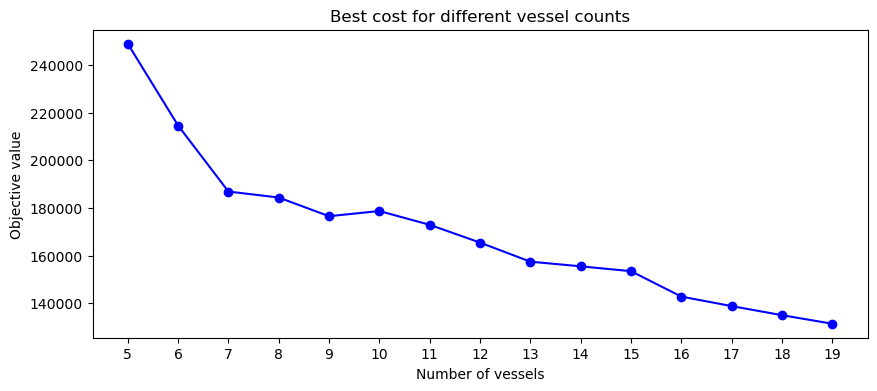

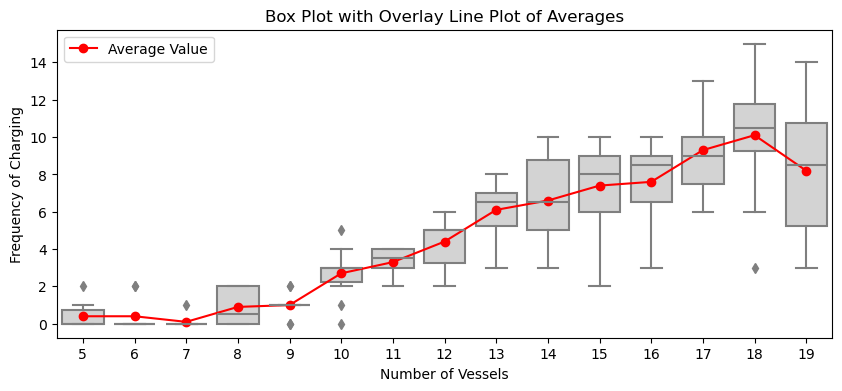

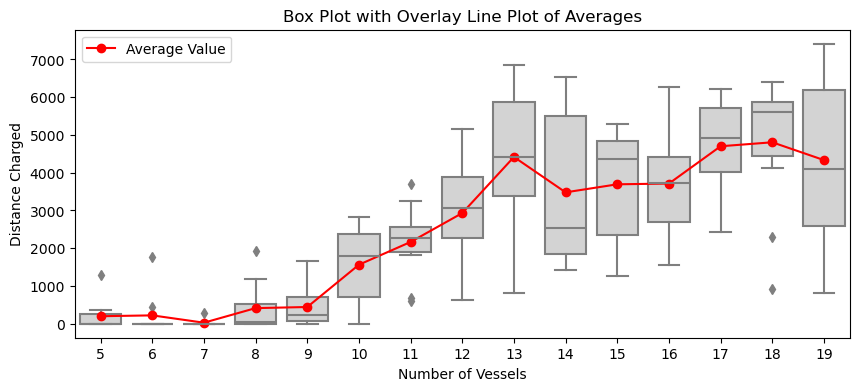

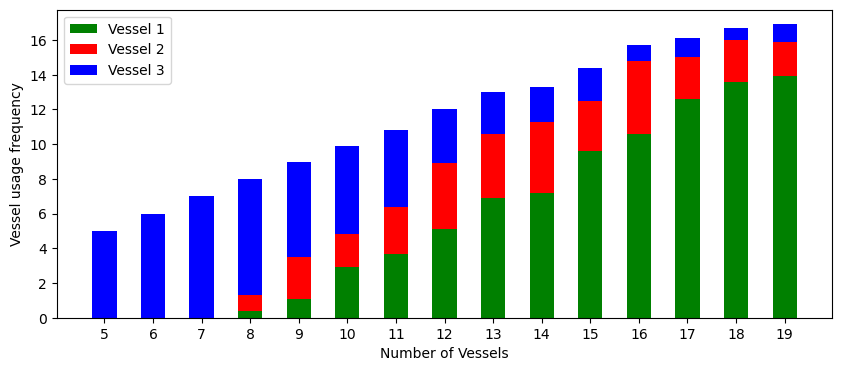

In [231]:
exII_results_plot(exII)